<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230710_DD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [6]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [74]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [75]:
main_figsize=(15,3)

In [76]:
#  I(Z,B) > 0의 관계에 대해 z0를 전처리
class Sensitivity_Adapter(nn.Module):

    def __init__(self,input_dim):
        """Initializes DiscriminatorF with torch components."""

        super(Sensitivity_Adapter, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [77]:
# Define the Generator
class Generator(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self, input_dim=5):
        """Initializes Generator with torch components."""
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


In [78]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []

    if model2_ == None:
        ax = XS_test[:,0:b_dim]
        ref_ax = XS_train[:,0:b_dim]
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)

    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))

    print("Test f1 score: {}".format(f1))

    test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1,test_analysis_df

In [79]:

def test_all_data(generator,adapter,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)
    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if adapter == None:
            xs = X_live_unit[:,0:b_dim]
        else:
            xs = adapter(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = generator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({train_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({train_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [80]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        return torch.cat(h, dim=1)

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret
        return loss

In [81]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    seed_everything()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss(reduce=False)  # mean square error

    # Initializes generator and discriminator
    generator = Generator(b_dim).to(device)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]


    adapter = Sensitivity_Adapter(b_dim).to(device)
    optimizer_A = torch.optim.Adam(adapter.parameters(), lr=0.001)

    mine = Net(b_dim).to(device)
    optimizer_M = torch.optim.Adam(mine.parameters(), lr=0.01)
    loss_mse = customLoss(mine)

    kld_loss = nn.KLDivLoss(reduction='batchmean')

    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  b에 대한 x의 전처리
        # -------------------------------

        if lambda_f >= 0.0:
            xs = adapter(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range) # z0, b

            #org = torch.histc(XS_train[:,0:b_dim], bins=100, min=0, max=1)
            #trg = torch.histc(xs, bins=100, min=0, max=1)

            ml = torch.mean(mse_loss(xs, XS_train[:,0:b_dim]),dim=0)

            ## distribution의 변차를 최소화 한다. kld_loss ??
            #kl = torch.mean(kld_loss(trg.log(), org),dim=0)
            #
            a_loss =  torch.sum(ml) + torch.std(ml)
        else:
            xs = XS_train[:,0:b_dim]
            a_loss = torch.tensor(0.0)

        # -------------------
        #  Forwards Generator
        # -------------------
        #xs = torch.cat((XS_train[:,0:4], a_z.reshape(-1,1)), 1)
        #print(xs.shape)
        gen_y = generator(xs).reshape(-1,1)
        '''
        if do_mine and lambda_f >= 0.0:
            # -------------------
            #  Forwards MINE
            # -------------------
            # MI(x_t,y_t) < MI (x_t+1,y_t+1) 이되도록 학습한다.
            s = np.random.choice(range(500,train_len-500))
            mine_loss = loss_mse(xs[s-500:s],y_train[s-500:s]) - loss_mse(xs[s:s+500],y_train[s:s+500])
            #print(mine_loss.mean())
        else:
            mine_loss = torch.tensor(0.0)
        '''
        g_loss = bce_loss(gen_y, y_train.reshape(-1,1)) #+ torch.log(mine_loss.mean()+1)*0.001

        optimizer_A.zero_grad()
        #optimizer_M.zero_grad()
        optimizer_G.zero_grad()

        if lambda_f >= 0.0:
            loss = (1-lambda_f) * g_loss +  lambda_f * a_loss * alpha #* 0.05
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()
        #optimizer_M.step()
        optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        if lambda_f < 0.0:
            adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1,test_analysis = test_model(generator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Adapter loss':a_losses,'Classifier loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    plt.figure(figsize=main_figsize)
    plt.plot(a_losses,linewidth=1,label='Adapter loss')
    plt.plot(g_losses,linewidth=1,label='classifier loss')
    plt.ylabel('loss')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=2)
    plt.show()
    '''
    return f1,test_analysis,generator,adapter,df_loss

In [82]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [83]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [84]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis.values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf.values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({train_size})')
    #df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({bucket_size})',fontsize=15)
    plt.legend(loc=1,ncol=5)
    plt.show()

    return X,Y

In [85]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({train_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [134]:
def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0):

    columns = X.columns[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)
    lambda_f_set = [-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    #lambda_f_set = [-0.1,0.0,0.5,0.9] #[-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] #[-0.1,0.0,0.5] #
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table = {}
    result_table2 = {}
    result_table2['lambda']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]

    infos = {}
    for lambda_f in lambda_f_set:
        print(f'######################### Lambda {lambda_f} ###########################')
        f1,test_analysis,last_generator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_generator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table2['lambda'].append("Case #1, Normal model")
            result_table['Normal model'] = tad
        else:
            result_table2['lambda'].append(lambda_f)
            result_table[f'λ_{lambda_f}'] = tad

        infos[f'λ_{lambda_f}'] = (df_loss,df_mis,df_drf)
        result_table2['test_f1'].append(f1)
        result_table2['init_f1'].append(tad[0])
        result_table2['mean_f1'].append(np.mean(tad))
        result_table2['last_f1'].append(tad[-1])
        for clm in test_analysis.columns:
            if clm not in result_table2:
                result_table2[clm] = []
            result_table2[clm].append(test_analysis[clm].values[0])


    result_df = pd.DataFrame(result_table)
    result_df.plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    result4_df = pd.DataFrame(result_table2)

    max_mean_lambda = result4_df[result4_df['mean_f1']==np.max(result4_df[1:]['mean_f1'])]['lambda']

    print('max_mean_lambda=',max_mean_lambda.values[0])

    result_df[['Normal model',f'λ_{max_mean_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_loss,og_mis,og_drf = infos['λ_-0.1']
    df_loss,df_mis,df_drf = infos[f'λ_{max_mean_lambda.values[0]}']

    df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket',title='Training loss',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_mis.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='bucket',title='MI after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    og_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift for original data',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    df_drf.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',title='Drift after adapter',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    a1_columns = []
    b1_columns = []
    c1_columns = []
    a2_columns = []
    b2_columns = []
    c2_columns = []

    XS = X_train['b'].values
    for bk in np.unique(XS,axis = 0):
        a1_columns.append(f'Sum(MI{bk}.0)')
        b1_columns.append(f'Std(MI{bk}.0)')
        c1_columns.append(f'Ent(MI{bk}.0)')

        a2_columns.append(f'Sum(DR{bk}.0)')
        b2_columns.append(f'Std(DR{bk}.0)')
        c2_columns.append(f'Ent(DR{bk}.0)')

    for analysis_columns in [a1_columns,b1_columns,c1_columns,a2_columns,b2_columns,c2_columns]:
        print(analysis_columns)
        stds = np.std(result4_df[1:][analysis_columns],axis=1)

        print(stds)
        best_lambda = np.argmax(stds) #result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
        print('max_lambda=',best_lambda)
        result_df[['Normal model',f'λ_0.{best_lambda}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        best_lambda = np.argmin(stds) #result4_df[result4_df['sum * std']== np.min(result4_df[1:]['sum * std'])]['lambda']
        print('min_lambda=',best_lambda)
        result_df[['Normal model',f'λ_0.{best_lambda}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    for analysis_columns in ['Test Sum(MI)','Test Std(MI)','Test Ent(MI)','Test Sum(DR)','Test Std(DR)','Test Ent(DR)','TrainSum(MI)','TrainStd(MI)','TrainEnt(MI)']:
        best_lambda = result4_df[result4_df[analysis_columns]== np.max(result4_df[1:][analysis_columns])]['lambda']
        print(analysis_columns,'max_lambda=',best_lambda.values[0])
        result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        best_lambda = result4_df[result4_df[analysis_columns]== np.min(result4_df[1:][analysis_columns])]['lambda']
        print(analysis_columns,'min_lambda=',best_lambda.values[0])
        result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()
    '''

    best_lambda = result4_df[result4_df['TrainStd(MI)']== np.min(result4_df[1:]['TrainStd(MI)'])]['lambda']
    print('TrainStd(MI)','min_lambda=',best_lambda.values[0])
    result_df[['Normal model',f'λ_{best_lambda.values[0]}']].plot(figsize=main_figsize,linewidth=1,ylabel='F1 Score',xlabel='bucket',fontsize=10)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()


    return result4_df

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [135]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [136]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [137]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.37it/s]


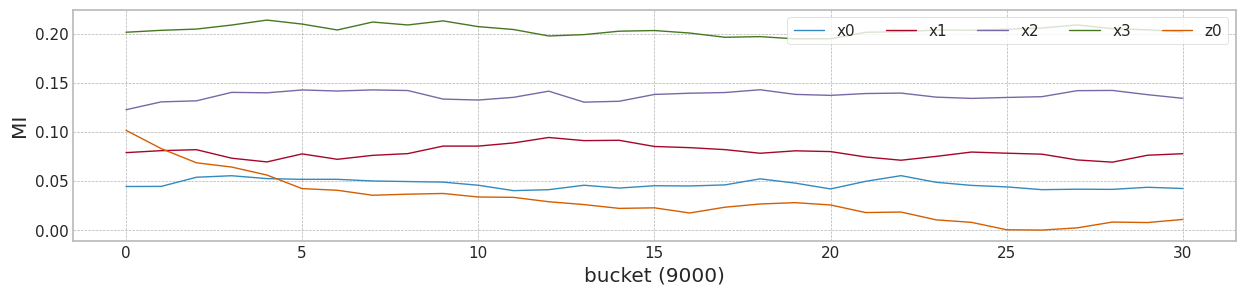

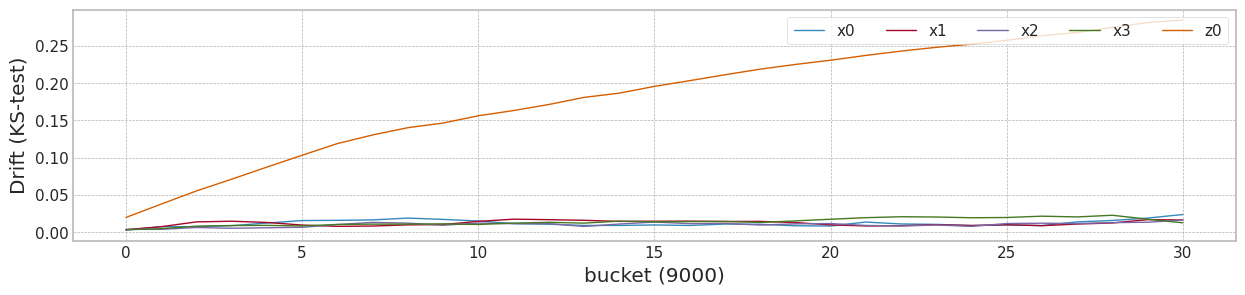

MI Analysis MI Max 0.20162, Min 0.04443, Mean 0.10986, Std 0.05270
cuda:0


100%|██████████| 1000/1000 [01:59<00:00,  8.38it/s]


MSE: 0.29
RMSE: 0.54


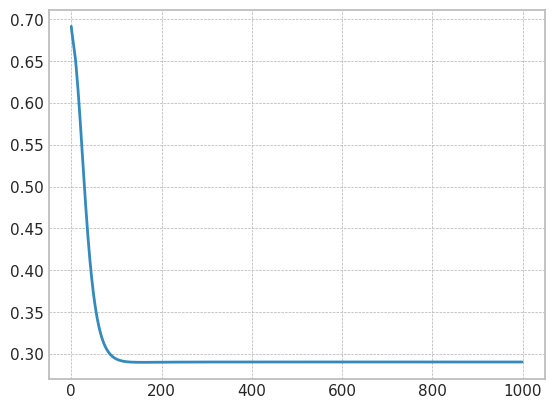

F1 Score:0.87616
Dataset structure X_train, torch.Size([9000, 5]) X_test, torch.Size([9000, 5]) X_live (39000, 5)
Truncate 36000 rows from live_set (39000, 5)


100%|██████████| 31/31 [00:00<00:00, 173.65it/s]


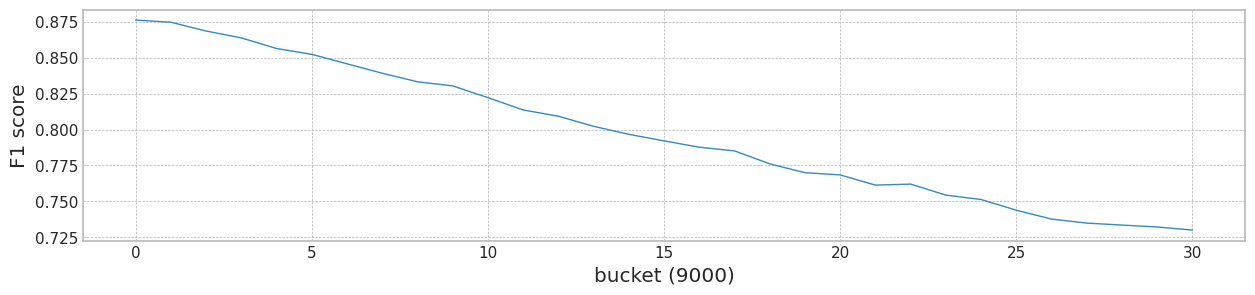

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.730016  0.876157  0.796927  0.730016  0.549316


In [138]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
mine = Net(X1.shape[1]).to(device)
optimizer = torch.optim.Adam(mine.parameters(), lr=0.01)
loss_mse = customLoss(mine)
plot_loss = []

x = torch.tensor(X1.values,dtype=torch.float32).to(device)
y = torch.tensor(Y1,dtype=torch.float32).to(device)

for epoch in tqdm(range(300)):
    mine.zero_grad()
    mine_loss = loss_mse(x,y)
    mine_loss.mean().backward()
    optimizer.step()
    plot_loss.append(-mine_loss.cpu().data.numpy())


plot_loss = np.asarray(plot_loss)
df_loss = pd.DataFrame(plot_loss,columns=X1.columns)

cuda:0


100%|██████████| 300/300 [00:02<00:00, 131.49it/s]


<Axes: >

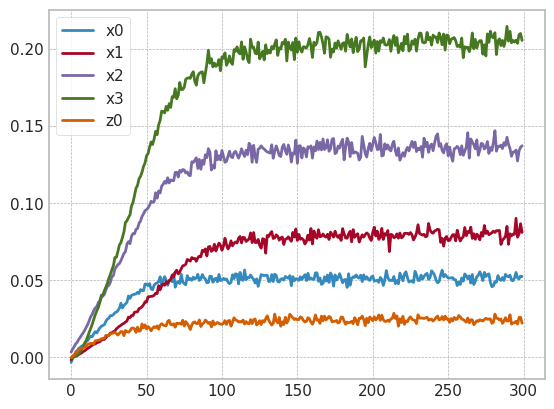

In [140]:
df_loss.plot()

In [141]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.421766   0
1      0.447230  0.556479  0.629077  0.735705  0.529014   0
2      0.489501  0.704159  0.760582  0.582973  0.570549   0
3      0.581446  0.301839  0.443337  0.515173  0.396001   0
4      0.571642  0.639275  0.524701  0.583380  0.561748   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.185740  39
39996  0.426322  0.302644  0.484909  0.587518  0.721101  39
39997  0.374186  0.587769  0.624447  0.598315  0.489479  39
39998  0.470439  0.265430  0.218971  0.645349  1.258888  39
39999  0.654583  0.419378  0.800216  0.614031  1.055564  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 653.74it/s]


Test f1 score: 0.8763676148796499
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.182717
dtype: float64
Mean F1 for all data: 0.7999359745907817
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.95it/s]


Test f1 score: 0.8799735478893419
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.08it/s]


mean of drift:
x0    1.000000
x1    0.778849
x2    0.853437
x3    1.000000
z0    0.981075
dtype: float64
Mean F1 for all data: 0.8365956615450646
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 238.35it/s]


Test f1 score: 0.8816848605138383
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.03it/s]


mean of drift:
x0    0.135821
x1    0.305122
x2    0.178176
x3    0.272254
z0    0.403763
dtype: float64
Mean F1 for all data: 0.7773677237490959
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.43it/s]


Test f1 score: 0.8775757575757576
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.99it/s]


mean of drift:
x0    0.296215
x1    0.256810
x2    0.178735
x3    0.226556
z0    0.187606
dtype: float64
Mean F1 for all data: 0.8237882166878296
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.17it/s]


Test f1 score: 0.8810020876826723
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.95it/s]


mean of drift:
x0    0.262853
x1    0.181953
x2    0.158957
x3    0.183814
z0    0.244022
dtype: float64
Mean F1 for all data: 0.8474757607480732
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 227.65it/s]


Test f1 score: 0.8805888168735581
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.89it/s]


mean of drift:
x0    0.207781
x1    0.167538
x2    0.120147
x3    0.147376
z0    0.192659
dtype: float64
Mean F1 for all data: 0.8465306396485185
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 232.45it/s]


Test f1 score: 0.8795088257866462
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


mean of drift:
x0    0.154735
x1    0.123179
x2    0.105513
x3    0.124982
z0    0.168681
dtype: float64
Mean F1 for all data: 0.84221881568299
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.57it/s]


Test f1 score: 0.8796580447172293
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.02it/s]


mean of drift:
x0    0.096971
x1    0.087616
x2    0.081215
x3    0.103989
z0    0.155842
dtype: float64
Mean F1 for all data: 0.8401190216775725
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.80it/s]


Test f1 score: 0.8797808219178082
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    0.056115
x1    0.072301
x2    0.067760
x3    0.089276
z0    0.110914
dtype: float64
Mean F1 for all data: 0.833756294729136
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.05it/s]


Test f1 score: 0.8793518721261221
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.00it/s]


mean of drift:
x0    0.039348
x1    0.039595
x2    0.041287
x3    0.072448
z0    0.133168
dtype: float64
Mean F1 for all data: 0.8267047800130374
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 224.32it/s]


Test f1 score: 0.8787315472936031
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.00it/s]


mean of drift:
x0    0.027659
x1    0.021197
x2    0.025366
x3    0.040487
z0    0.163333
dtype: float64
Mean F1 for all data: 0.8148511974860639


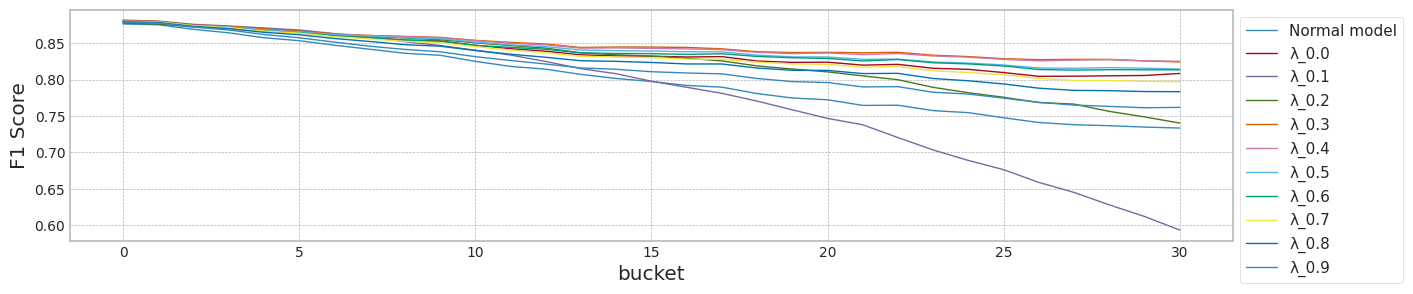

max_mean_lambda= 0.3


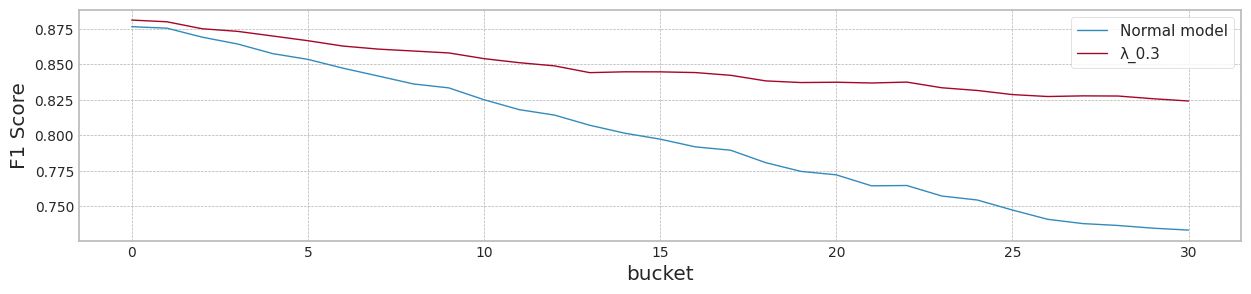

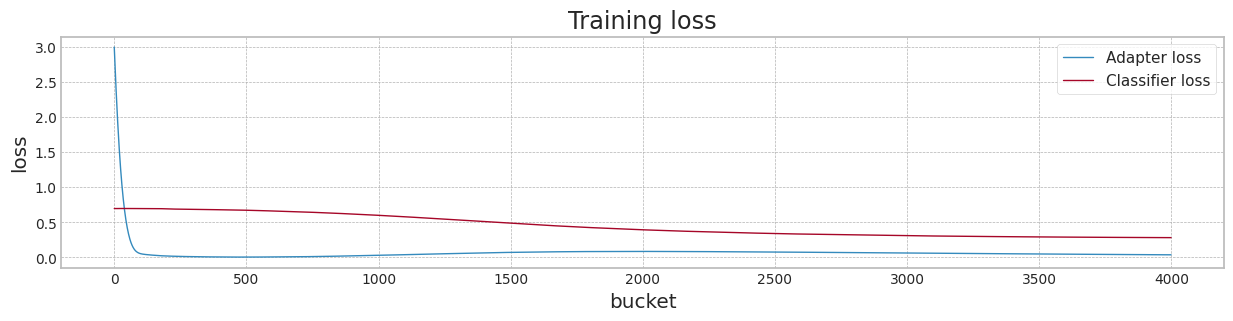

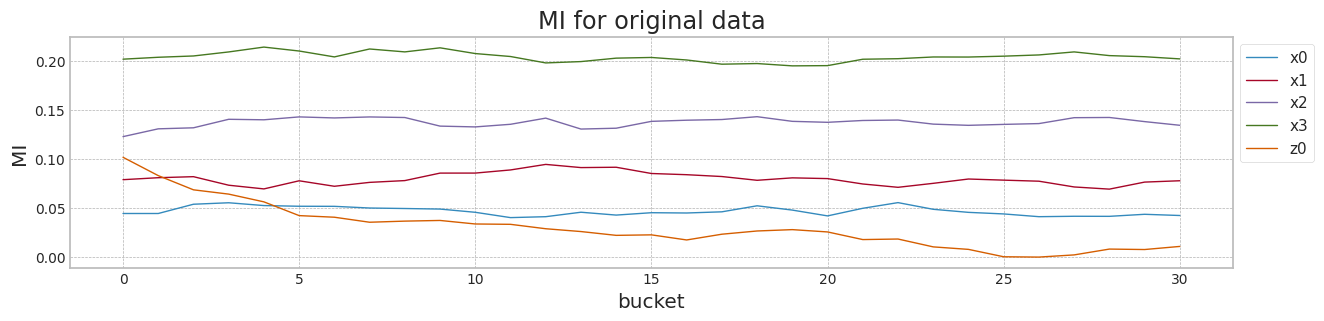

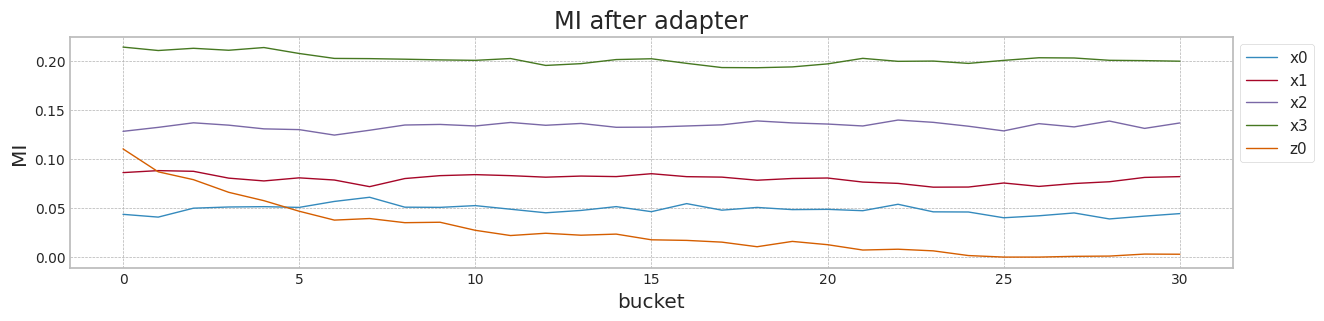

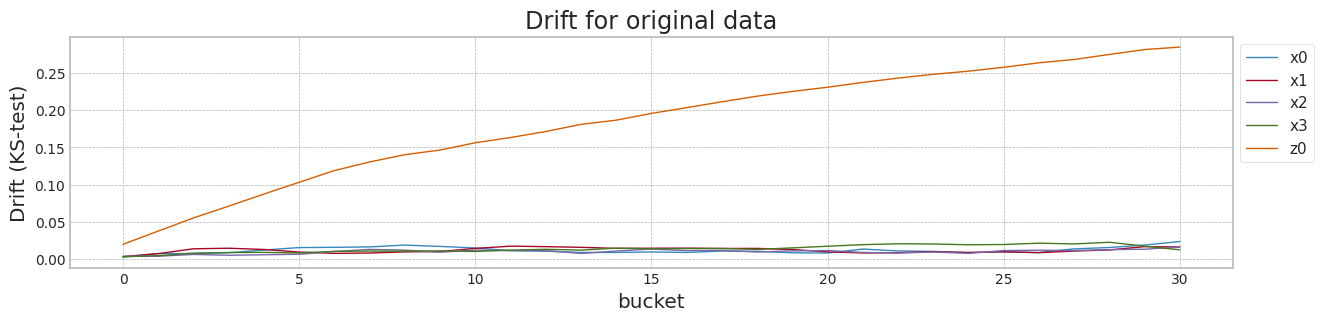

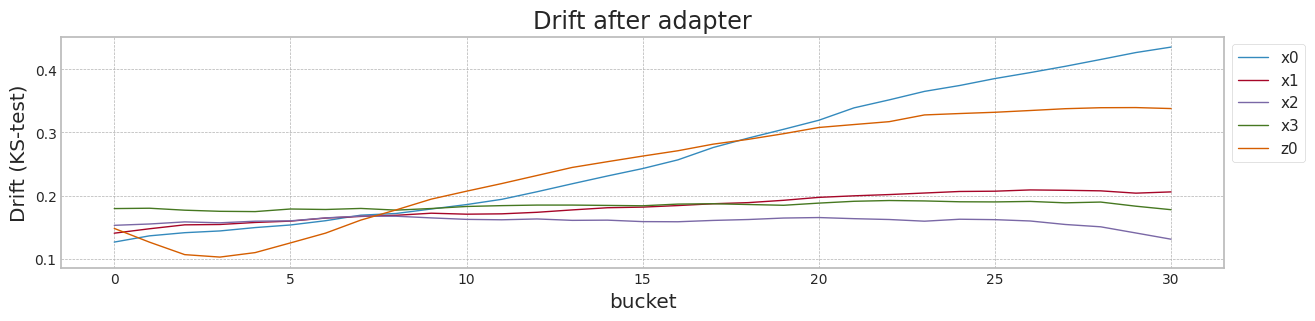

TrainStd(MI) min_lambda= 0.5


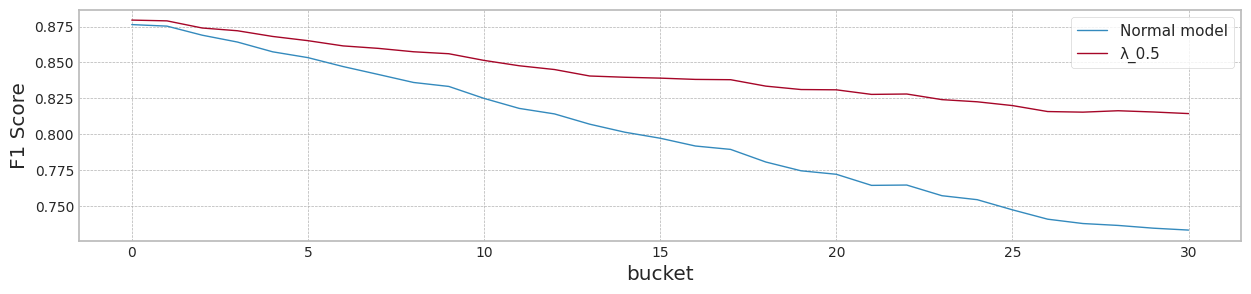

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.876368  0.876368  0.799936  0.733370    0.747456   
1                     0.0  0.879974  0.879974  0.836596  0.808373    0.748009   
2                     0.1  0.881685  0.881685  0.777368  0.593177    0.748664   
3                     0.2  0.877576  0.877576  0.823788  0.740164    0.748693   
4                     0.3  0.881002  0.881002  0.847476  0.824119    0.747894   
5                     0.4  0.880589  0.880589  0.846531  0.825107    0.747849   
6                     0.5  0.879509  0.879509  0.842219  0.814441    0.748325   
7                     0.6  0.879658  0.879658  0.840119  0.813323    0.747461   
8                     0.7  0.879781  0.879781  0.833756  0.797062    0.745093   
9                     0.8  0.879352  0.879352  0.826705  0.783290    0.745706   
10                    0.9  0.878732  0.878732  0.814851  0.761789    0.746693   

    Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0     0.093809    1.406225    0.181000    0.028441  ...    1.419276   
1     0.093577    1.407615    4.990000    0.004000  ...    1.609304   
2     0.093217    1.410120    1.138222    0.051129  ...    1.577062   
3     0.093365    1.409792    1.039556    0.054972  ...    1.563542   
4     0.093819    1.406666    0.865111    0.043392  ...    1.582125   
5     0.093791    1.406899    0.730667    0.042075  ...    1.574077   
6     0.093877    1.406957    0.617444    0.038754  ...    1.599612   
7     0.093725    1.406615    0.507000    0.035931  ...    1.593033   
8     0.093910    1.404312    0.416000    0.024870  ...    1.592214   
9     0.093801    1.405224    0.304556    0.015455  ...    1.577446   
10    0.093955    1.404767    0.186778    0.008496  ...    1.500626   

    TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0       0.584127      0.053828      1.505461      0.549369      0.052727   
1       0.541578      0.058669      1.447349      0.518837      0.057100   
2       0.624049      0.055645      1.507409      0.597608      0.052029   
3       0.621379      0.056729      1.501964      0.598498      0.054697   
4       0.611589      0.055885      1.501197      0.582535      0.056510   
5       0.632199      0.055597      1.508940      0.602985      0.050785   
6       0.614227      0.053472      1.511121      0.588902      0.053146   
7       0.635452      0.054797      1.518215      0.598648      0.055537   
8       0.611038      0.057650      1.492036      0.587778      0.056358   
9       0.603476      0.058607      1.492477      0.583333      0.058732   
10      0.597394      0.055376      1.502146      0.573782      0.051747   

    Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0       1.496972      0.000000      0.000000           NaN  
1       1.450883      4.977000      0.009145      1.609396  
2       1.515797      0.938778      0.028141      1.598654  
3       1.505486      0.863556      0.035638      1.588846  
4       1.492785      0.734444      0.017989      1.602110  
5       1.522351      0.600333      0.014558      1.602284  
6       1.507811      0.481889      0.014228      1.598982  
7       1.506857      0.376000      0.013646      1.593611  
8       1.492205      0.293222      0.010029      1.595525  
9       1.487258      0.204556      0.009098      1.586473  
10      1.512763      0.108111      0.003563      1.596326  

[11 rows x 68 columns]

In [142]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [143]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [144]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [145]:
x1.shape

(40000, 5)

In [146]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [147]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

5
21325


### 실험

MI Analysis MI Max 0.22746, Min 0.00677, Mean 0.06988, Std 0.08433
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


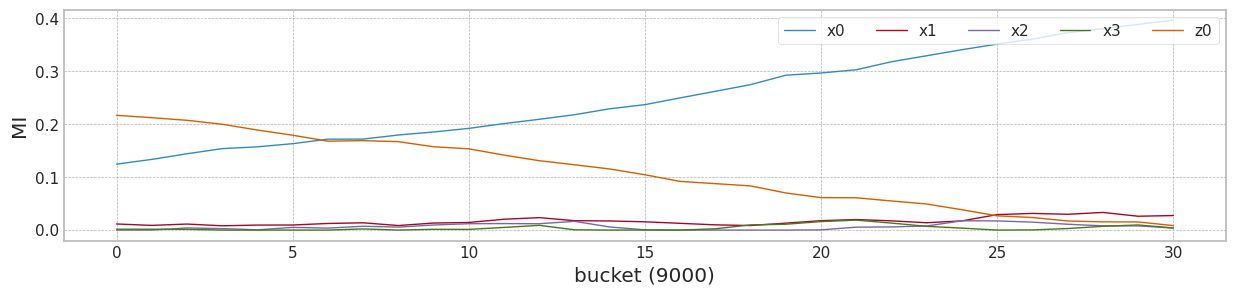

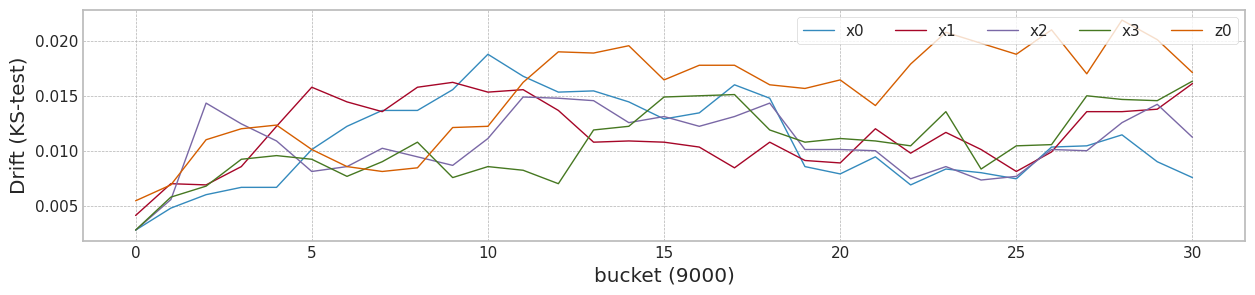

MI Analysis MI Max 0.21692, Min 0.00000, Mean 0.07095, Std 0.08666
cuda:0


100%|██████████| 1000/1000 [01:59<00:00,  8.34it/s]


MSE: 0.03
RMSE: 0.19


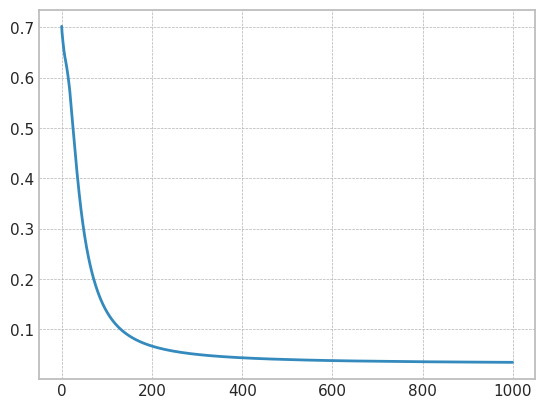

F1 Score:0.98767
Dataset structure X_train, torch.Size([9000, 5]) X_test, torch.Size([9000, 5]) X_live (39000, 5)
Truncate 36000 rows from live_set (39000, 5)


100%|██████████| 31/31 [00:00<00:00, 169.84it/s]


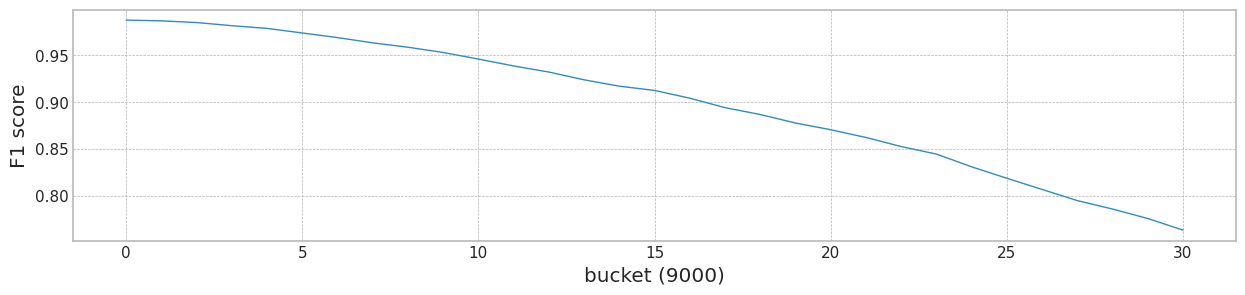

    test_f1   init_f1   mean_f1   last_f1   SUM(MI)
0  0.763475  0.987668  0.899322  0.763475  0.354735


In [148]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [149]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.525799  0.497734  0.329063  0.549493  0.366139   0
1      0.610533  0.420412  0.508390  0.580336  0.662926   0
2      0.556874  0.464734  0.669603  0.724770  0.486574   0
3      0.344341  0.646524  0.340976  0.528780  0.611850   0
4      0.503142  0.550860  0.598773  0.465698  0.487044   0
...         ...       ...       ...       ...       ...  ..
39995  0.333622  0.399822  0.303105  0.605408  0.709407  39
39996  0.358451  0.483875  0.341855  0.574439  0.695384  39
39997  0.559469  0.343824  0.542547  0.575250  0.504288  39
39998  0.433692  0.530132  0.301231  0.282353  0.762158  39
39999  0.538629  0.637825  0.358726  0.768301  0.522435  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 676.63it/s]


Test f1 score: 0.9662005741272339
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.010828
x1    0.011545
x2    0.010692
x3    0.010649
z0    0.015151
dtype: float64
Mean F1 for all data: 0.8790432735532113
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.46it/s]


Test f1 score: 0.9964838924261142
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.999323
x1    0.808889
x2    0.944792
x3    1.000000
z0    0.967961
dtype: float64
Mean F1 for all data: 0.9270536625977882
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.46it/s]


Test f1 score: 0.984525382147575
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.506477
x1    0.280082
x2    0.145473
x3    0.125351
z0    0.417108
dtype: float64
Mean F1 for all data: 0.8909794674598516
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.55it/s]


Test f1 score: 0.9810787913018922
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.551728
x1    0.205237
x2    0.105373
x3    0.058753
z0    0.261244
dtype: float64
Mean F1 for all data: 0.8273148909700057
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.46it/s]


Test f1 score: 0.9779785431959345
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.18it/s]


mean of drift:
x0    0.523100
x1    0.160011
x2    0.080789
x3    0.032018
z0    0.202090
dtype: float64
Mean F1 for all data: 0.8191853105539587
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.52it/s]


Test f1 score: 0.9755868544600939
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.11it/s]


mean of drift:
x0    0.428168
x1    0.129516
x2    0.063283
x3    0.016706
z0    0.157039
dtype: float64
Mean F1 for all data: 0.8897926771039671
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.40it/s]


Test f1 score: 0.9732870934483082
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.462208
x1    0.100513
x2    0.043867
x3    0.011305
z0    0.137272
dtype: float64
Mean F1 for all data: 0.833858923226526
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.67it/s]


Test f1 score: 0.959221501390176
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


mean of drift:
x0    0.346154
x1    0.071892
x2    0.022262
x3    0.030154
z0    0.127989
dtype: float64
Mean F1 for all data: 0.8936706459904881
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 235.24it/s]


Test f1 score: 0.9559190462988633
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.222025
x1    0.052244
x2    0.014806
x3    0.022108
z0    0.105204
dtype: float64
Mean F1 for all data: 0.8800120981414093
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.53it/s]


Test f1 score: 0.9533192155418471
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.26it/s]


mean of drift:
x0    0.153821
x1    0.034566
x2    0.011627
x3    0.017434
z0    0.077491
dtype: float64
Mean F1 for all data: 0.8831724783990944
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.96it/s]


Test f1 score: 0.9504442612439314
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.052692
x1    0.018211
x2    0.012559
x3    0.014419
z0    0.051215
dtype: float64
Mean F1 for all data: 0.8831012151235406


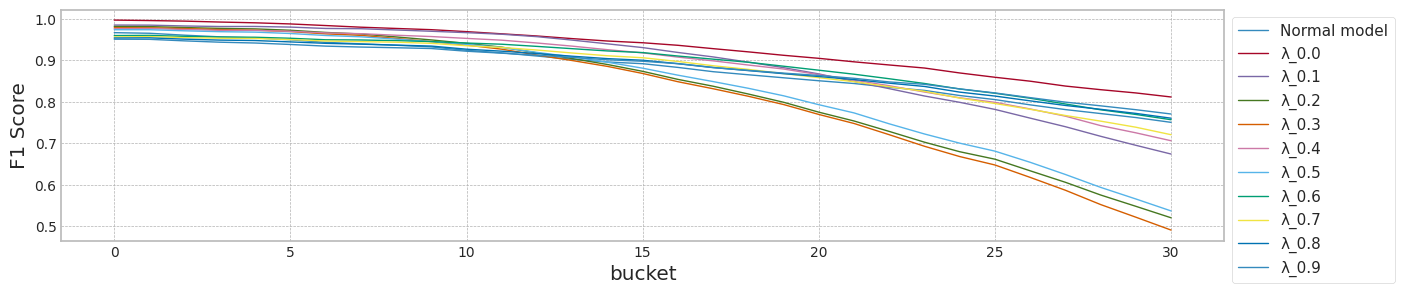

max_mean_lambda= 0.0


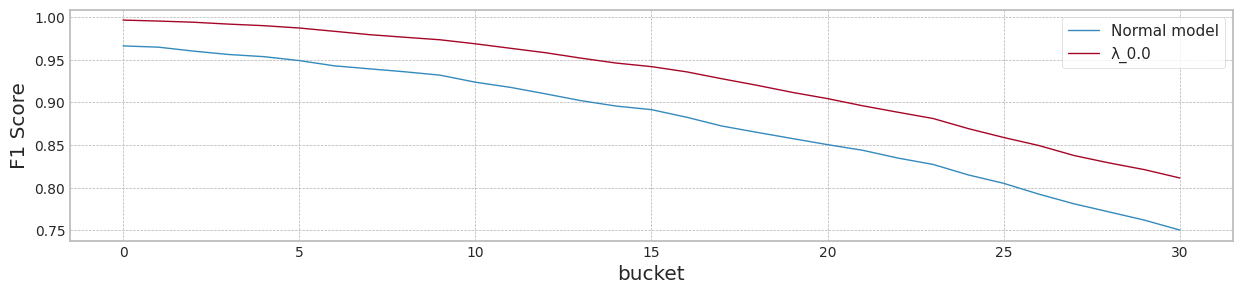

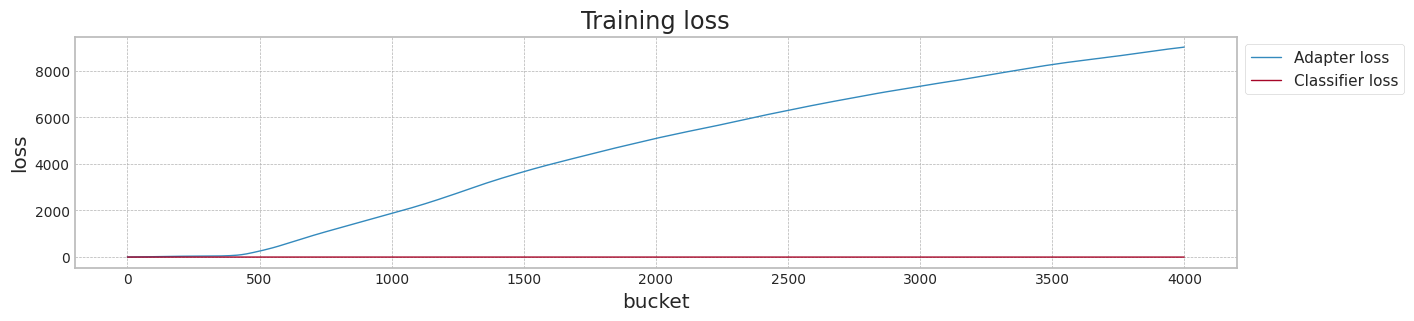

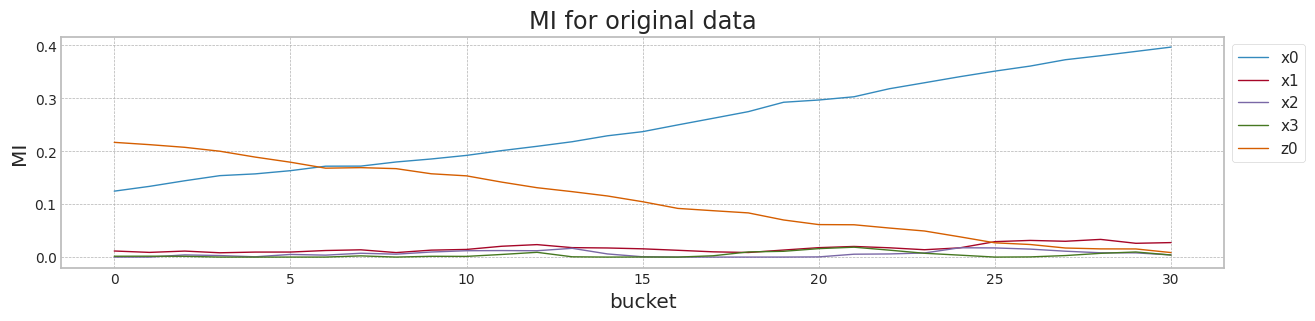

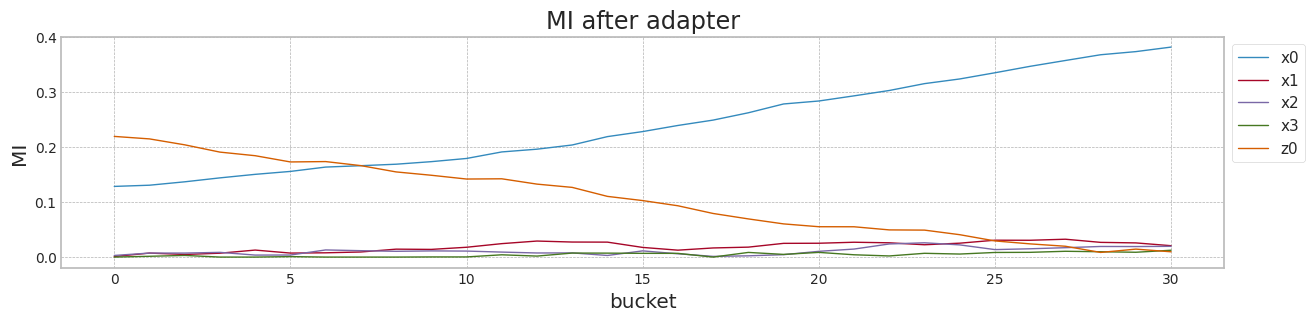

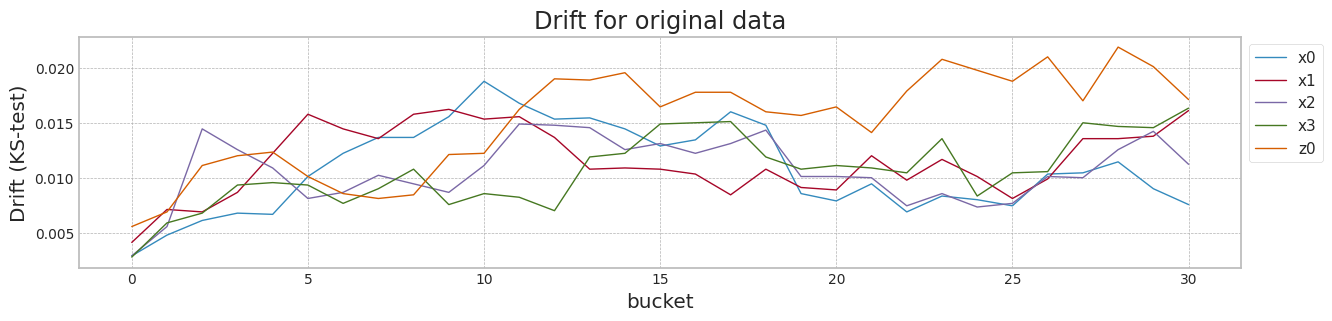

TrainStd(MI) min_lambda= 0.0


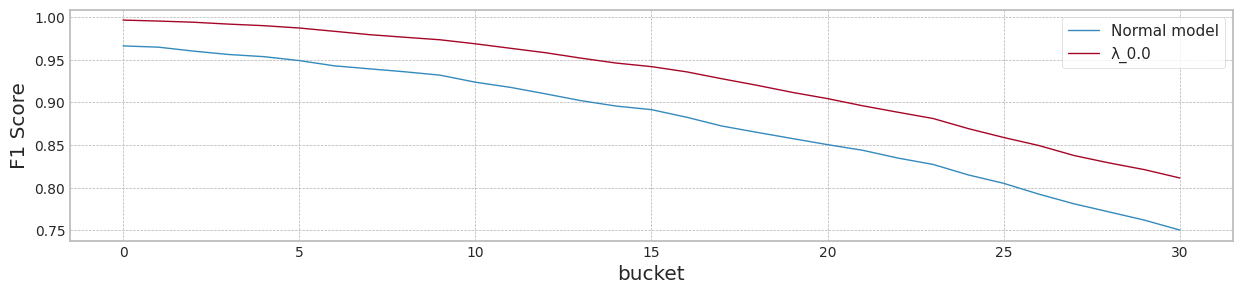

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.966201  0.966201  0.879043  0.750255    0.361798   
1                     0.0  0.996484  0.996484  0.927054  0.811347    0.362055   
2                     0.1  0.984525  0.984525  0.890979  0.673980    0.361256   
3                     0.2  0.981079  0.981079  0.827315  0.520525    0.361995   
4                     0.3  0.977979  0.977979  0.819185  0.490922    0.361630   
5                     0.4  0.975587  0.975587  0.889793  0.706001    0.361205   
6                     0.5  0.973287  0.973287  0.833859  0.537031    0.360955   
7                     0.6  0.959222  0.959222  0.893671  0.756637    0.361948   
8                     0.7  0.955919  0.955919  0.880012  0.720545    0.360716   
9                     0.8  0.953319  0.953319  0.883172  0.760257    0.361354   
10                    0.9  0.950444  0.950444  0.883101  0.770367    0.361189   

    Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0     0.102542    0.654025    0.096111    0.005867  ...    1.585123   
1     0.102498    0.658523    4.853000    0.042561  ...    1.605423   
2     0.102665    0.646326    1.317444    0.101475  ...    1.512008   
3     0.102467    0.656873    0.975889    0.090937  ...    1.470429   
4     0.102260    0.657835    0.775444    0.084139  ...    1.425952   
5     0.102234    0.657247    0.628556    0.075899  ...    1.423641   
6     0.102343    0.652812    0.513222    0.065801  ...    1.418669   
7     0.102257    0.660811    0.441000    0.054610  ...    1.441349   
8     0.102339    0.653249    0.356444    0.047355  ...    1.431282   
9     0.102356    0.654607    0.279444    0.036517  ...    1.455092   
10    0.102478    0.648503    0.179889    0.018462  ...    1.491603   

    TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0       0.356049      0.089014      0.787555      0.354657      0.086642   
1       0.368341      0.088257      0.879081      0.351418      0.089212   
2       0.376129      0.091600      0.817703      0.374304      0.090534   
3       0.374629      0.091002      0.835636      0.381997      0.089408   
4       0.372035      0.090983      0.810237      0.363001      0.088642   
5       0.387277      0.093327      0.835362      0.380516      0.089757   
6       0.385547      0.094513      0.814803      0.373698      0.089865   
7       0.365332      0.088866      0.798680      0.356287      0.086697   
8       0.367466      0.090333      0.792844      0.366321      0.089255   
9       0.370565      0.092122      0.779151      0.370621      0.089396   
10      0.372932      0.092409      0.788728      0.366556      0.088122   

    Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0       0.804710      0.000000      0.000000           NaN  
1       0.719771      4.774000      0.054289      1.607805  
2       0.839071      1.293889      0.103956      1.523015  
3       0.880957      0.967667      0.093580      1.480306  
4       0.806480      0.771333      0.086639      1.429818  
5       0.878296      0.623444      0.078221      1.377742  
6       0.850029      0.509556      0.069424      1.333408  
7       0.793130      0.430778      0.058018      1.374199  
8       0.790395      0.334444      0.049334      1.325065  
9       0.811282      0.242778      0.038967      1.271172  
10      0.821540      0.145667      0.026062      1.196911  

[11 rows x 68 columns]

In [150]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [151]:
import matplotlib.pyplot as plt

seed_everything(2)

data_size = 40000
cor = np.asarray([2.5, 1.2, 0.9 , 1.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 10*cor_const * ii)
    e1 = np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)


In [152]:
m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

9.231010910364422


19386

### 실험

MI Analysis MI Max 0.19778, Min 0.00159, Mean 0.07319, Std 0.07958
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


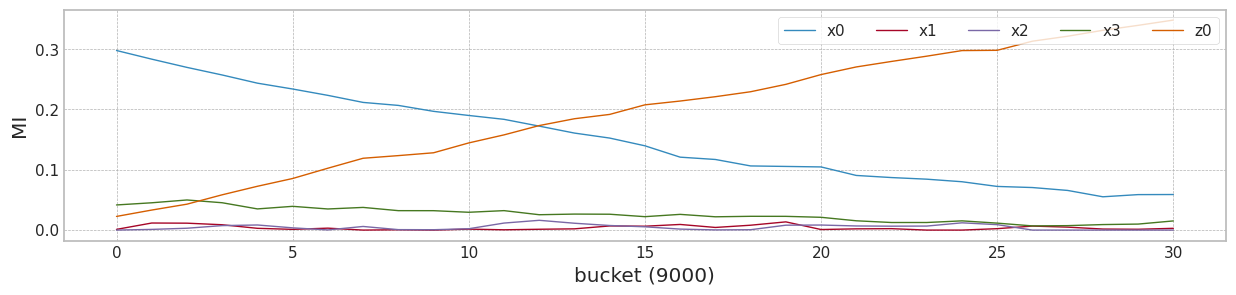

In [153]:
columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)

train_size = 9000
test_size = 1000

X1,Y1 = check_mi_drift(X2, y2,train_size, test_size)

In [154]:
bucket_size = 1000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.410279  0.209059  0.415497  0.727384  0.391721   0
1      0.457001  0.519404  0.479812  0.521037  0.401229   0
2      0.187431  0.428404  0.396307  0.408316  0.393364   0
3      0.676882  0.616554  0.624402  0.490002  0.423167   0
4      0.231854  0.479819  0.377091  0.562758  0.395391   0
...         ...       ...       ...       ...       ...  ..
39995  0.342999  0.553462  0.404624  0.588307 -0.255762  39
39996  0.399868  0.617391  0.449924  0.425269 -0.347659  39
39997  0.389933  0.496568  0.201780  0.495907  1.654762  39
39998  0.407933  0.571901  0.798504  0.658386  0.325860  39
39999  0.425227  0.455123  0.456839  0.491625  0.729285  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 699.82it/s]


Test f1 score: 0.9422071499222835
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.014294
x1    0.014247
x2    0.009111
x3    0.010627
z0    0.336724
dtype: float64
Mean F1 for all data: 0.9378763986662148
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.93it/s]


Test f1 score: 0.9796143250688705
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    0.718599
x1    0.956520
x2    1.000000
x3    1.000000
z0    0.565473
dtype: float64
Mean F1 for all data: 0.9578255757249903
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.18it/s]


Test f1 score: 0.9663448275862069
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


mean of drift:
x0    0.393645
x1    0.260419
x2    0.346670
x3    0.425652
z0    0.428319
dtype: float64
Mean F1 for all data: 0.9292365996701349
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 237.04it/s]


Test f1 score: 0.9642610735476749
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.17it/s]


mean of drift:
x0    0.394022
x1    0.153441
x2    0.280885
x3    0.300821
z0    0.414573
dtype: float64
Mean F1 for all data: 0.9334940081860624
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.81it/s]


Test f1 score: 0.9573381195637167
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


mean of drift:
x0    0.342211
x1    0.139201
x2    0.399405
x3    0.263792
z0    0.388176
dtype: float64
Mean F1 for all data: 0.9345282140852432
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.83it/s]


Test f1 score: 0.9546019042362357
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.259882
x1    0.119835
x2    0.093609
x3    0.202258
z0    0.369384
dtype: float64
Mean F1 for all data: 0.9429858176809233
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.26it/s]


Test f1 score: 0.952433628318584
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.221828
x1    0.096760
x2    0.060939
x3    0.164896
z0    0.360824
dtype: float64
Mean F1 for all data: 0.9426990513531807
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.31it/s]


Test f1 score: 0.945303867403315
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.130581
x1    0.076577
x2    0.031584
x3    0.118086
z0    0.355513
dtype: float64
Mean F1 for all data: 0.9457745063234582
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 236.90it/s]


Test f1 score: 0.9415836101882613
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.099308
x1    0.058409
x2    0.024097
x3    0.087581
z0    0.350219
dtype: float64
Mean F1 for all data: 0.9440749224371351
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 229.52it/s]


Test f1 score: 0.9381686813950257
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.05it/s]


mean of drift:
x0    0.108541
x1    0.042029
x2    0.017925
x3    0.058047
z0    0.347151
dtype: float64
Mean F1 for all data: 0.9387773133773673
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.83it/s]


Test f1 score: 0.9416037999441184
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.24it/s]


mean of drift:
x0    0.082814
x1    0.026824
x2    0.013875
x3    0.036401
z0    0.342875
dtype: float64
Mean F1 for all data: 0.9373005135344449


max_mean_lambda= 0.0


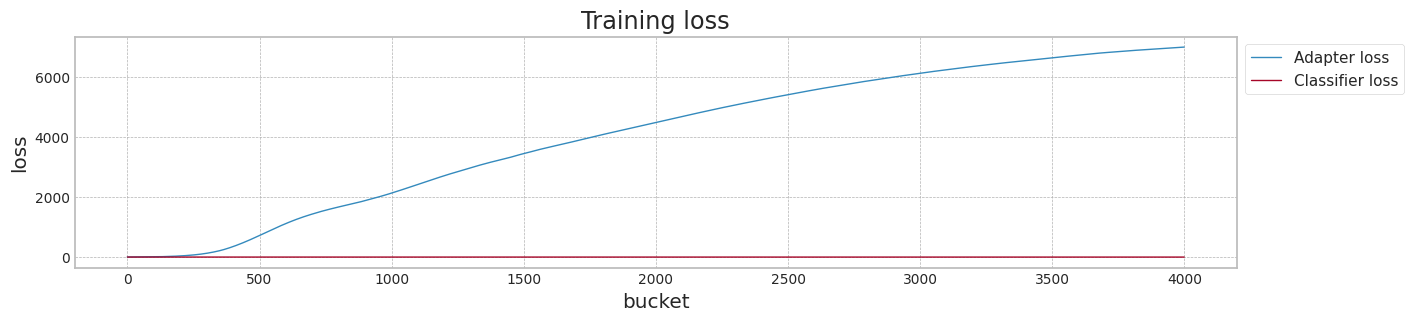

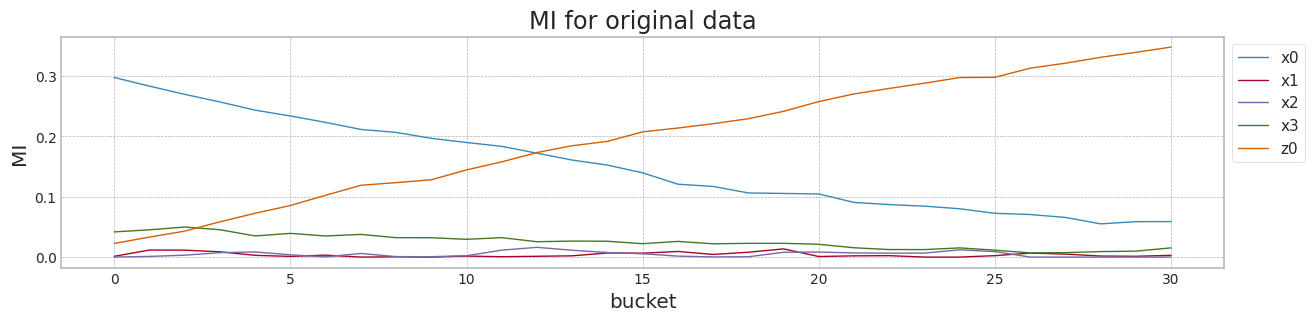

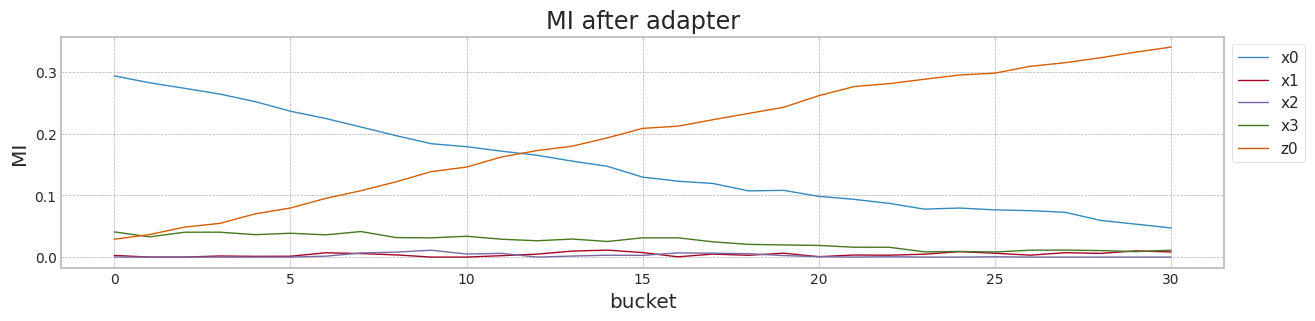

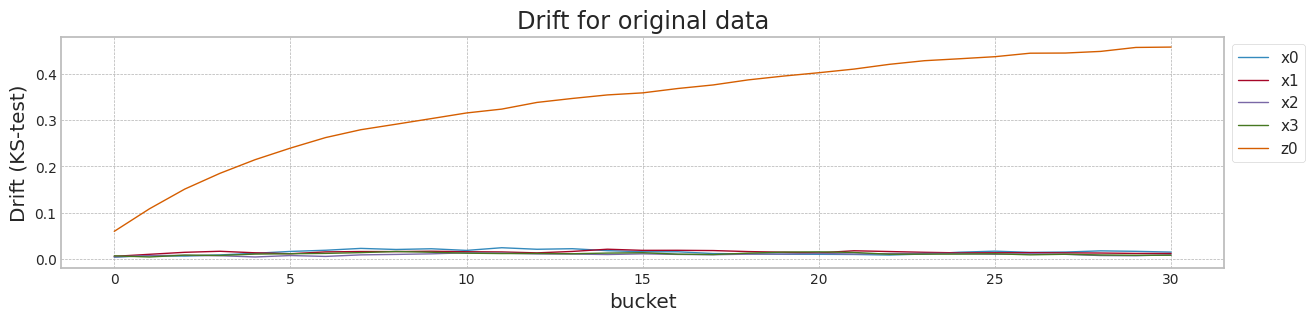

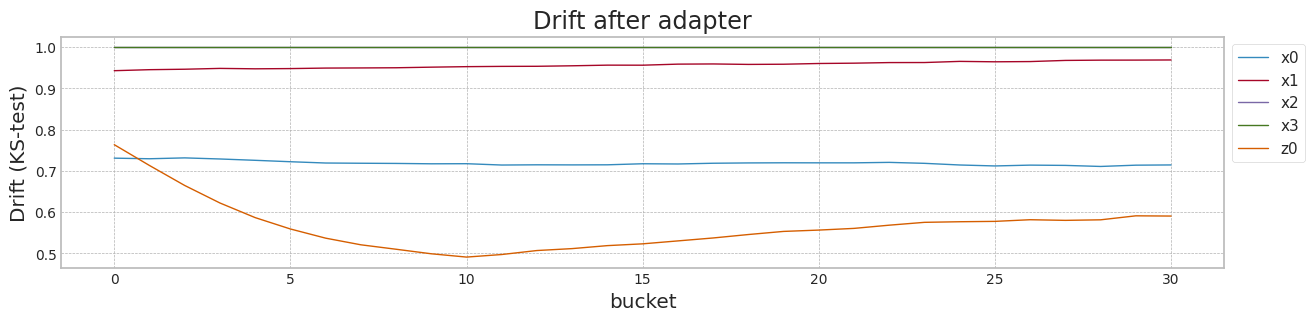

TrainStd(MI) min_lambda= 0.4


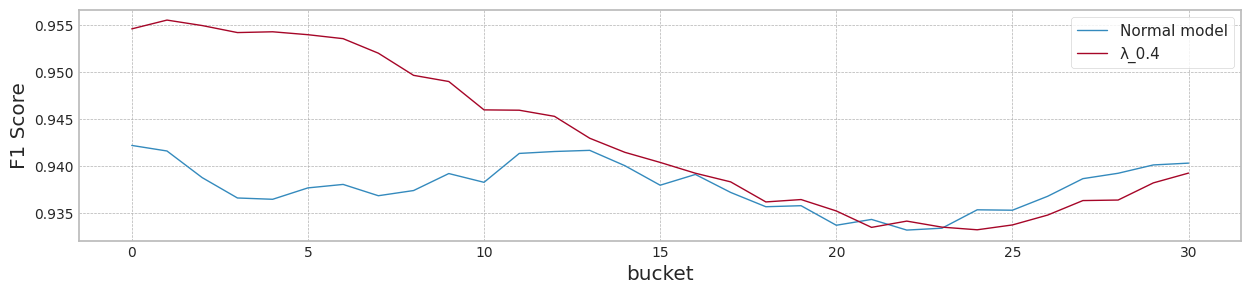

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.942207  0.942207  0.937876  0.940325    0.382206   
1                     0.0  0.979614  0.979614  0.957826  0.950632    0.382553   
2                     0.1  0.966345  0.966345  0.929237  0.910753    0.382011   
3                     0.2  0.964261  0.964261  0.933494  0.916917    0.381986   
4                     0.3  0.957338  0.957338  0.934528  0.923862    0.381025   
5                     0.4  0.954602  0.954602  0.942986  0.939266    0.382173   
6                     0.5  0.952434  0.952434  0.942699  0.937752    0.383069   
7                     0.6  0.945304  0.945304  0.945775  0.942162    0.381231   
8                     0.7  0.941584  0.941584  0.944075  0.942193    0.382933   
9                     0.8  0.938169  0.938169  0.938777  0.929813    0.381171   
10                    0.9  0.941604  0.941604  0.937301  0.931154    0.381901   

    Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0     0.125230    0.597607    0.477000    0.135991  ...    1.013100   
1     0.125179    0.600162    4.682667    0.096302  ...    1.589611   
2     0.124697    0.605809    1.759000    0.173106  ...    1.571863   
3     0.124717    0.604964    1.308556    0.075970  ...    1.576732   
4     0.124656    0.600541    1.296222    0.085840  ...    1.530740   
5     0.124628    0.608328    1.131222    0.135733  ...    1.512339   
6     0.124580    0.613878    0.988444    0.128319  ...    1.478345   
7     0.124851    0.598794    0.900889    0.124292  ...    1.440975   
8     0.124864    0.607417    0.800556    0.123449  ...    1.388124   
9     0.125138    0.593750    0.707222    0.126927  ...    1.290156   
10    0.125007    0.599545    0.590667    0.131716  ...    1.157105   

    TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0       0.379631      0.116674      0.680939      0.363392      0.113602   
1       0.384378      0.116095      0.686761      0.366106      0.111276   
2       0.399146      0.117481      0.761817      0.396725      0.112119   
3       0.387076      0.112432      0.763193      0.384104      0.106871   
4       0.411750      0.115045      0.841214      0.400587      0.110134   
5       0.406447      0.112073      0.883266      0.395567      0.106968   
6       0.414187      0.115882      0.850322      0.392259      0.111379   
7       0.407264      0.115374      0.803685      0.407846      0.110317   
8       0.390352      0.121347      0.675772      0.380818      0.115422   
9       0.391796      0.116688      0.702870      0.375879      0.110986   
10      0.398001      0.113629      0.767177      0.383822      0.108884   

    Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0       0.603972      0.000000      0.000000           NaN  
1       0.658704      4.436222      0.117086      1.600567  
2       0.811395      1.323556      0.087644      1.550500  
3       0.809236      1.158556      0.064817      1.569819  
4       0.837340      1.107000      0.089119      1.531200  
5       0.879875      0.776889      0.072834      1.488689  
6       0.789539      0.645000      0.064857      1.474402  
7       0.890658      0.547333      0.059858      1.449367  
8       0.689219      0.430333      0.051294      1.422057  
9       0.711445      0.308667      0.043389      1.364584  
10      0.774190      0.176222      0.030324      1.274117  

[11 rows x 68 columns]

In [155]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [156]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

MI Analysis MI Max 0.20278, Min 0.05089, Mean 0.11172, Std 0.05282
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


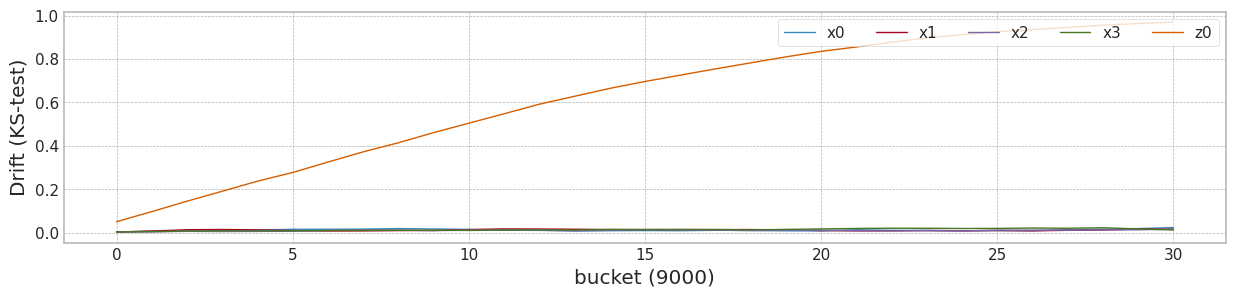

In [157]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [158]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

x0        x1        x2        x3        z0   b
0      0.520974  0.392205  0.600995  0.478669  0.477486   0
1      0.447230  0.556479  0.629077  0.735705  0.578715   0
2      0.489501  0.704159  0.760582  0.582973  0.354045   0
3      0.581446  0.301839  0.443337  0.515173  0.360338   0
4      0.571642  0.639275  0.524701  0.583380  0.597569   0
...         ...       ...       ...       ...       ...  ..
39995  0.346158  0.267147  0.513105  0.599663  0.989291  39
39996  0.426322  0.302644  0.484909  0.587518  1.004704  39
39997  0.374186  0.587769  0.624447  0.598315  1.321791  39
39998  0.470439  0.265430  0.218971  0.645349  1.148847  39
39999  0.654583  0.419378  0.800216  0.614031  1.319193  39

[40000 rows x 6 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 691.46it/s]


Test f1 score: 0.9102426454799226
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


mean of drift:
x0    0.011903
x1    0.011896
x2    0.010036
x3    0.013871
z0    0.624315
dtype: float64
Mean F1 for all data: 0.760588938342107
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 234.31it/s]


Test f1 score: 0.9214844180156371
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.16it/s]


mean of drift:
x0    1.000000
x1    0.999975
x2    1.000000
x3    1.000000
z0    0.949491
dtype: float64
Mean F1 for all data: 0.9234330649454561
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.94it/s]


Test f1 score: 0.9223995597138138
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.634337
x1    0.302774
x2    0.284921
x3    0.294122
z0    0.416416
dtype: float64
Mean F1 for all data: 0.9099908828676143
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 235.74it/s]


Test f1 score: 0.9209629548202705
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.458695
x1    0.251595
x2    0.227168
x3    0.315351
z0    0.329280
dtype: float64
Mean F1 for all data: 0.9223313214613517
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.31it/s]


Test f1 score: 0.9193938062815724
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.19it/s]


mean of drift:
x0    0.585667
x1    0.206581
x2    0.238434
x3    0.290717
z0    0.314703
dtype: float64
Mean F1 for all data: 0.9186133502010901
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.47it/s]


Test f1 score: 0.9171792618629174
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


mean of drift:
x0    0.426781
x1    0.240781
x2    0.252022
x3    0.294953
z0    0.335054
dtype: float64
Mean F1 for all data: 0.9168558086227492
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.49it/s]


Test f1 score: 0.9155808606153508
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


mean of drift:
x0    0.093957
x1    0.229692
x2    0.239720
x3    0.302498
z0    0.327746
dtype: float64
Mean F1 for all data: 0.9165805045696589
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.35it/s]


Test f1 score: 0.920589841616603
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


mean of drift:
x0    0.087068
x1    0.216477
x2    0.210828
x3    0.261599
z0    0.331534
dtype: float64
Mean F1 for all data: 0.9187651081370587
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.53it/s]


Test f1 score: 0.9217182730047973
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.25it/s]


mean of drift:
x0    0.111222
x1    0.174427
x2    0.188928
x3    0.241946
z0    0.364147
dtype: float64
Mean F1 for all data: 0.911775965865216
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 243.11it/s]


Test f1 score: 0.9210211841390549
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


mean of drift:
x0    0.096921
x1    0.145029
x2    0.175251
x3    0.214262
z0    0.429254
dtype: float64
Mean F1 for all data: 0.8893525650694046
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.75it/s]


Test f1 score: 0.9187729531216244
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.27it/s]


mean of drift:
x0    0.069871
x1    0.101724
x2    0.117111
x3    0.150287
z0    0.511824
dtype: float64
Mean F1 for all data: 0.8391483883362254


max_mean_lambda= 0.0


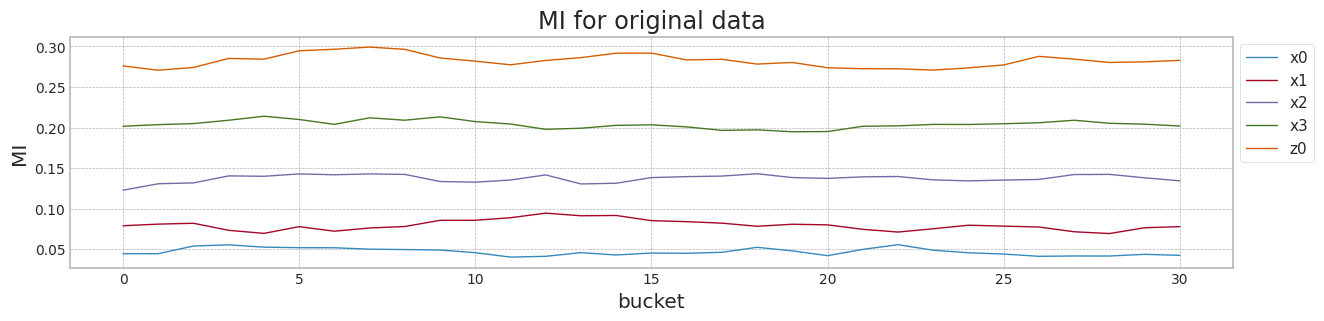

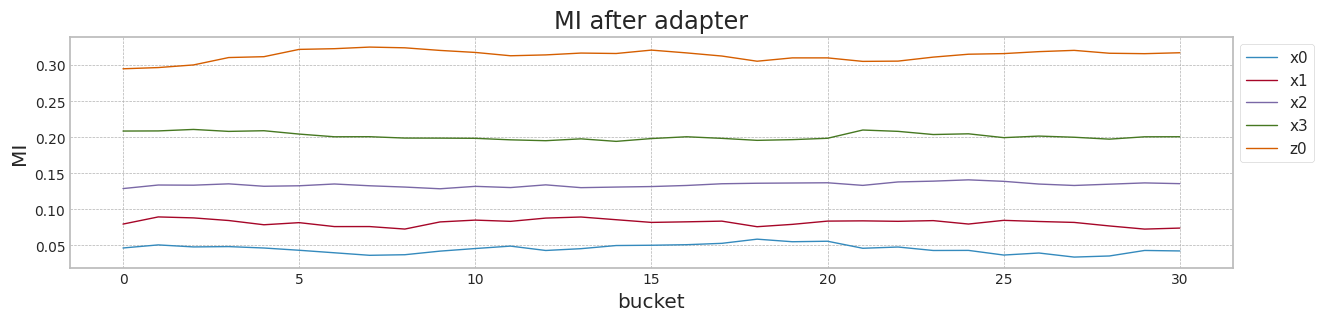

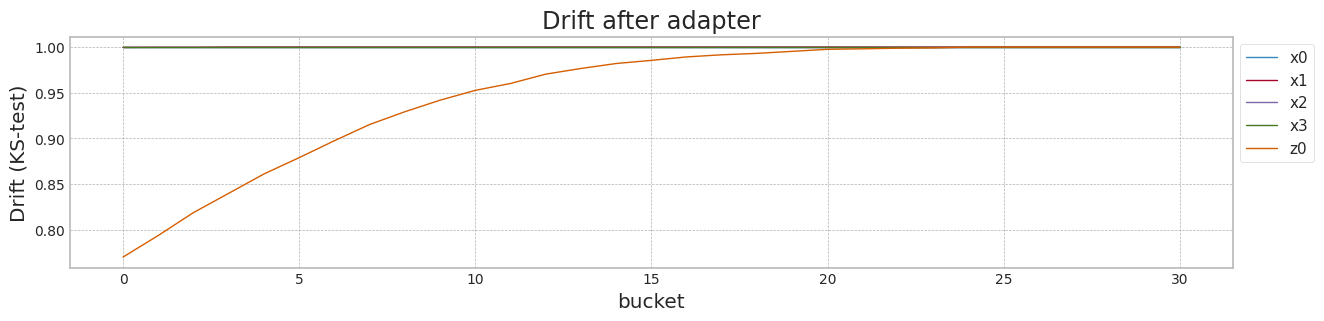

TrainStd(MI) min_lambda= 0.9


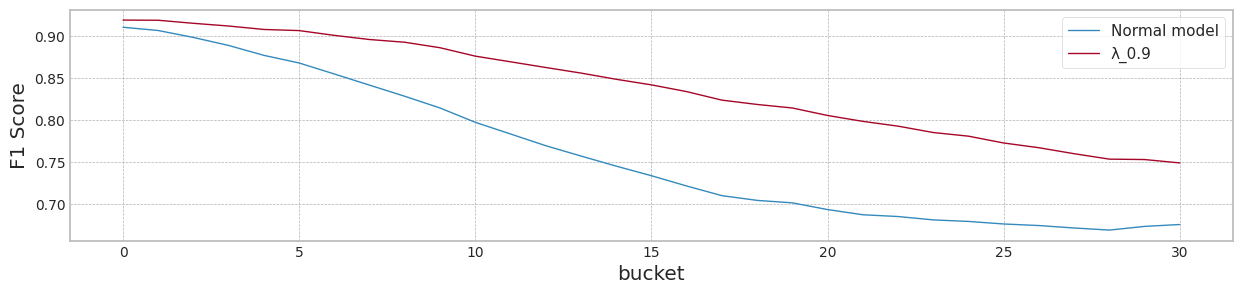

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.910243  0.910243  0.760589  0.675771    0.804112   
1                     0.0  0.921484  0.921484  0.923433  0.919479    0.804267   
2                     0.1  0.922400  0.922400  0.909991  0.880824    0.804763   
3                     0.2  0.920963  0.920963  0.922331  0.920263    0.800969   
4                     0.3  0.919394  0.919394  0.918613  0.914837    0.813502   
5                     0.4  0.917179  0.917179  0.916856  0.914436    0.806363   
6                     0.5  0.915581  0.915581  0.916581  0.916631    0.802168   
7                     0.6  0.920590  0.920590  0.918765  0.915733    0.803994   
8                     0.7  0.921718  0.921718  0.911776  0.895299    0.803517   
9                     0.8  0.921021  0.921021  0.889353  0.846340    0.803635   
10                    0.9  0.918773  0.918773  0.839148  0.748977    0.803578   

    Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0     0.112842    1.367717    0.302111    0.076825  ...    1.033720   
1     0.112734    1.368491    4.636889    0.145244  ...    1.607540   
2     0.112621    1.369380    1.076111    0.061019  ...    1.605243   
3     0.113228    1.362965    0.997000    0.090559  ...    1.542275   
4     0.110628    1.386460    1.136222    0.141038  ...    1.486756   
5     0.112159    1.373388    0.941889    0.094161  ...    1.530588   
6     0.112388    1.368489    0.612778    0.062683  ...    1.580274   
7     0.112800    1.368151    0.523556    0.065051  ...    1.531876   
8     0.113057    1.366187    0.479556    0.063955  ...    1.533154   
9     0.112927    1.367238    0.407556    0.057228  ...    1.498836   
10    0.113034    1.366277    0.328778    0.062054  ...    1.407021   

    TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0       0.738968      0.084225      1.445611      0.723681      0.084119   
1       0.760609      0.092955      1.422195      0.758240      0.090159   
2       0.806811      0.101656      1.410218      0.810347      0.097377   
3       0.802439      0.098705      1.423536      0.809009      0.097678   
4       0.773251      0.103201      1.379236      0.776420      0.101015   
5       0.783886      0.099610      1.408696      0.791876      0.097359   
6       0.806095      0.094697      1.440208      0.802409      0.094142   
7       0.789184      0.092430      1.442141      0.774899      0.094626   
8       0.781401      0.094661      1.428960      0.783579      0.094328   
9       0.795377      0.092275      1.442180      0.782435      0.092541   
10      0.775160      0.088755      1.446841      0.768595      0.084485   

    Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0       1.437383      0.000000      0.000000           NaN  
1       1.430605      4.770222      0.091745      1.604566  
2       1.431330      1.029778      0.036318      1.593886  
3       1.428969      1.003333      0.081410      1.533502  
4       1.393585      1.124000      0.137641      1.449038  
5       1.420658      0.933889      0.094276      1.495577  
6       1.441345      0.608111      0.034092      1.572087  
7       1.427027      0.453000      0.040063      1.509935  
8       1.431449      0.373222      0.029552      1.533087  
9       1.434297      0.272111      0.022158      1.528442  
10      1.461112      0.152778      0.011232      1.544329  

[11 rows x 68 columns]

In [159]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
result_df

## synthetic data의 생성 (Case #5 - Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우)

### Dataset 준비

In [160]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


### 실험

MI Analysis MI Max 0.14553, Min 0.02498, Mean 0.08409, Std 0.04454
Dataset structure X_train, (9000, 5) X_test, (9000, 5) X_live (39000, 5)
Truncate 8000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (31, 9000, 5)


100%|██████████| 31/31 [00:05<00:00,  5.35it/s]


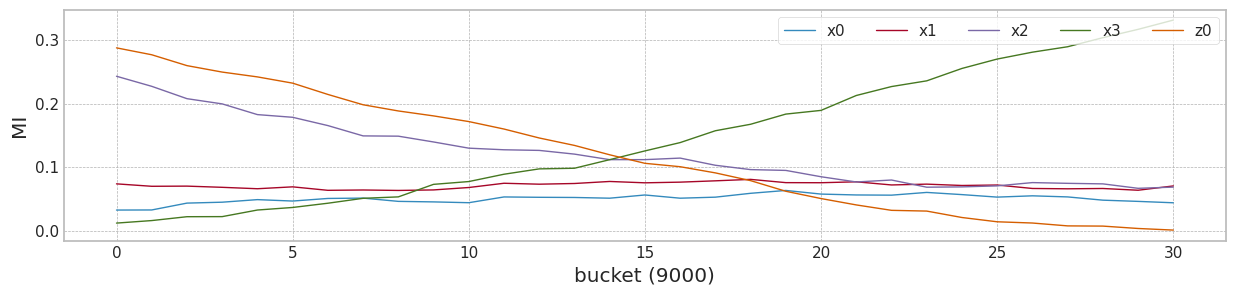

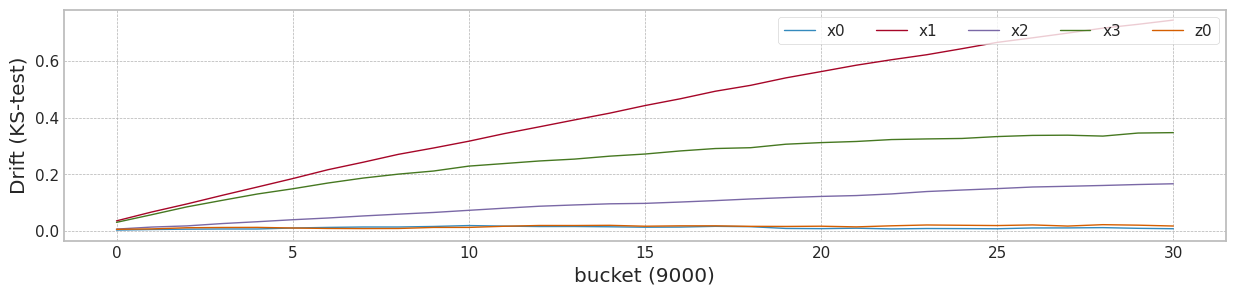

In [161]:
columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)

#train_size = 2100
#test_size = 400

X1,Y1 = check_mi_drift(X4, y4,train_size, test_size)

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:05<00:00, 712.17it/s]


Test f1 score: 0.9227268417559494
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.98it/s]


mean of drift:
x0    0.010828
x1    0.426663
x2    0.094563
x3    0.246330
z0    0.015151
dtype: float64
Mean F1 for all data: 0.7642579759110337
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 244.22it/s]


Test f1 score: 0.940003870718018
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.999993
x1    0.935487
x2    1.000000
x3    1.000000
z0    0.597477
dtype: float64
Mean F1 for all data: 0.8560618375867243
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.03it/s]


Test f1 score: 0.9391976800386661
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.22it/s]


mean of drift:
x0    0.261538
x1    0.240387
x2    0.334305
x3    0.336961
z0    0.336093
dtype: float64
Mean F1 for all data: 0.8698628774144446
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.72it/s]


Test f1 score: 0.9376269219611256
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.255642
x1    0.286996
x2    0.288039
x3    0.271649
z0    0.287742
dtype: float64
Mean F1 for all data: 0.8601248340511486
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 240.34it/s]


Test f1 score: 0.9300364193981216
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.32it/s]


mean of drift:
x0    0.231061
x1    0.286412
x2    0.336577
x3    0.401125
z0    0.201090
dtype: float64
Mean F1 for all data: 0.8160774057230072
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.25it/s]


Test f1 score: 0.9288718929254303
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


mean of drift:
x0    0.215394
x1    0.309176
x2    0.290215
x3    0.549251
z0    0.266240
dtype: float64
Mean F1 for all data: 0.7939514924747921
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 242.73it/s]


Test f1 score: 0.9265547500953834
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.17it/s]


mean of drift:
x0    0.184186
x1    0.324437
x2    0.256864
x3    0.223889
z0    0.240409
dtype: float64
Mean F1 for all data: 0.777879881769373
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.61it/s]


Test f1 score: 0.9233985934233035
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.23it/s]


mean of drift:
x0    0.142810
x1    0.341036
x2    0.272935
x3    0.195348
z0    0.216430
dtype: float64
Mean F1 for all data: 0.7587380039635159
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 239.18it/s]


Test f1 score: 0.9202919154582504
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:05<00:00,  5.21it/s]


mean of drift:
x0    0.104351
x1    0.356366
x2    0.228401
x3    0.202401
z0    0.182025
dtype: float64
Mean F1 for all data: 0.7408101660205111
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:17<00:00, 231.00it/s]


Test f1 score: 0.9164227028047974
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  4.93it/s]


mean of drift:
x0    0.063480
x1    0.371183
x2    0.156928
x3    0.217857
z0    0.133437
dtype: float64
Mean F1 for all data: 0.7329901845853308
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:16<00:00, 241.14it/s]


Test f1 score: 0.9129535626997556
X_live.shape (39000, 6)
Truncate 8000 rows from live_set (39000, 6)
Search MI & Drift...for X_live_set torch.Size([31, 9000, 6])


100%|██████████| 31/31 [00:06<00:00,  5.10it/s]


mean of drift:
x0    0.033896
x1    0.394405
x2    0.140301
x3    0.232918
z0    0.092685
dtype: float64
Mean F1 for all data: 0.722598542008207


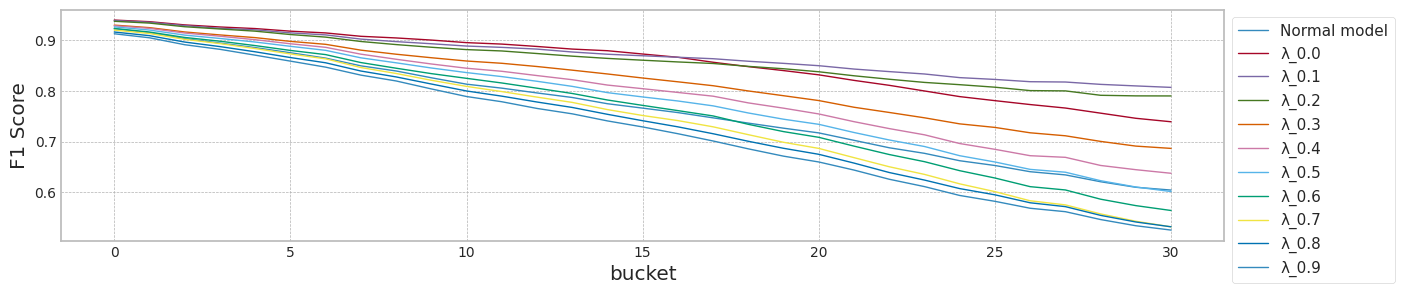

max_mean_lambda= 0.1


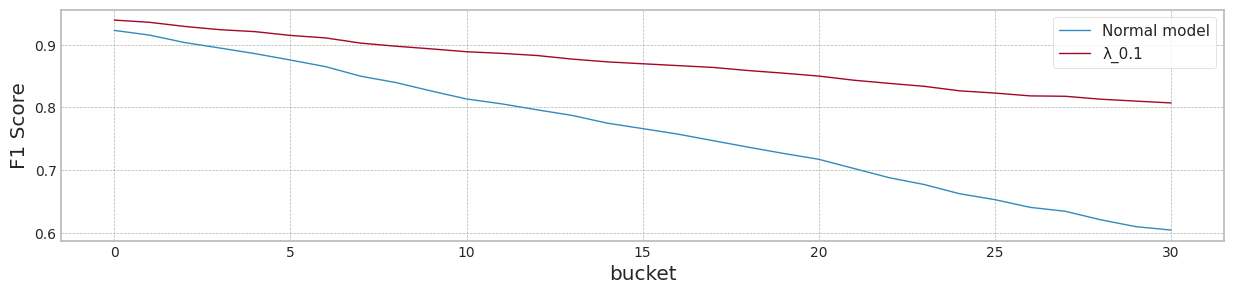

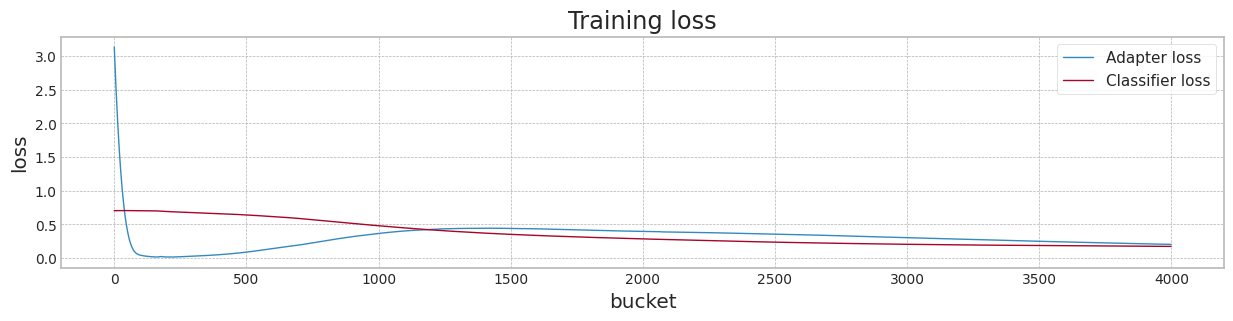

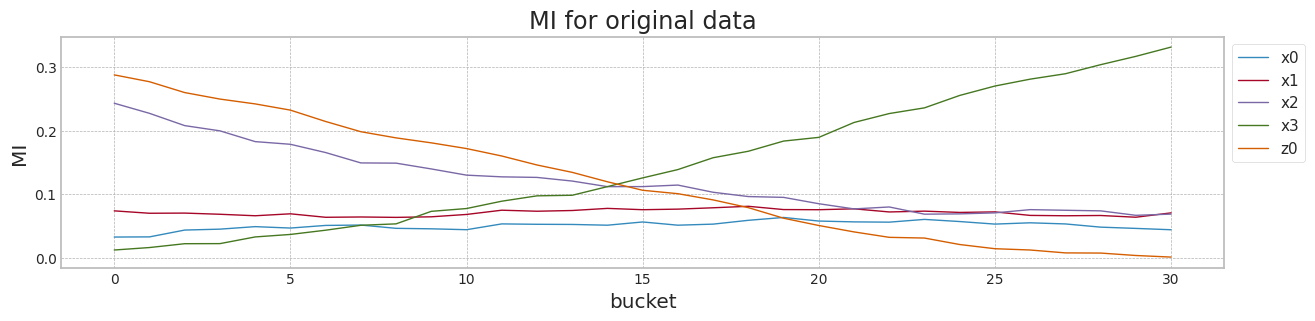

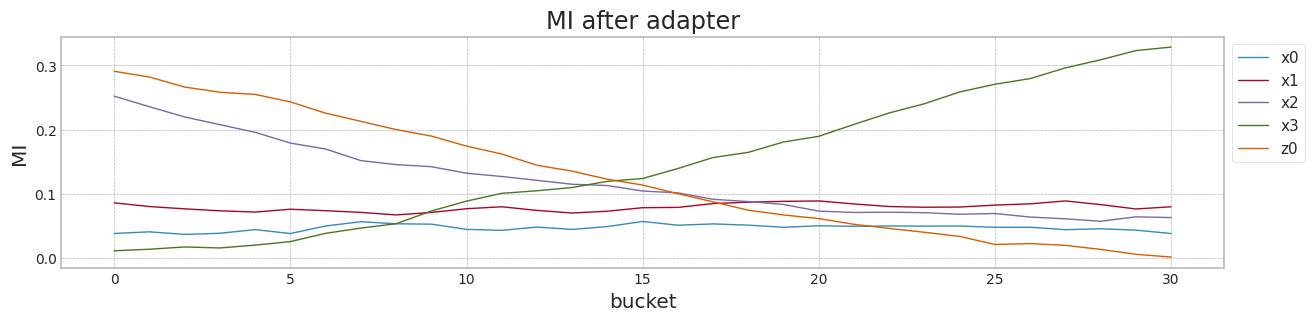

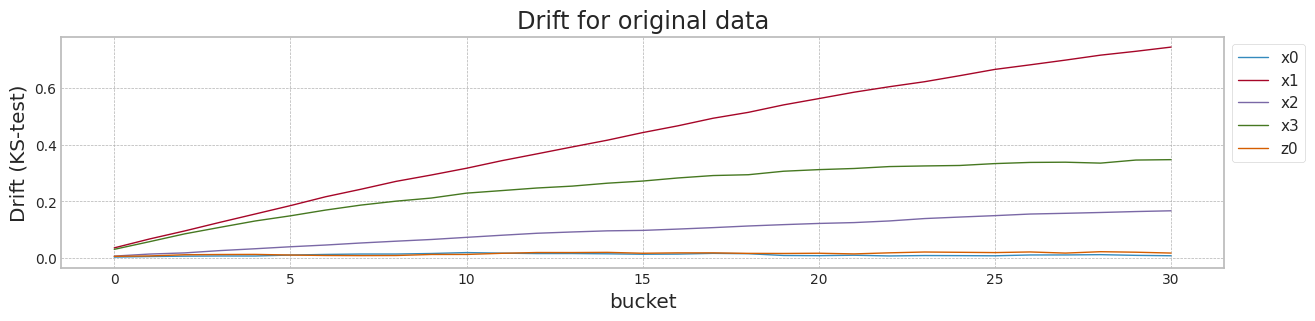

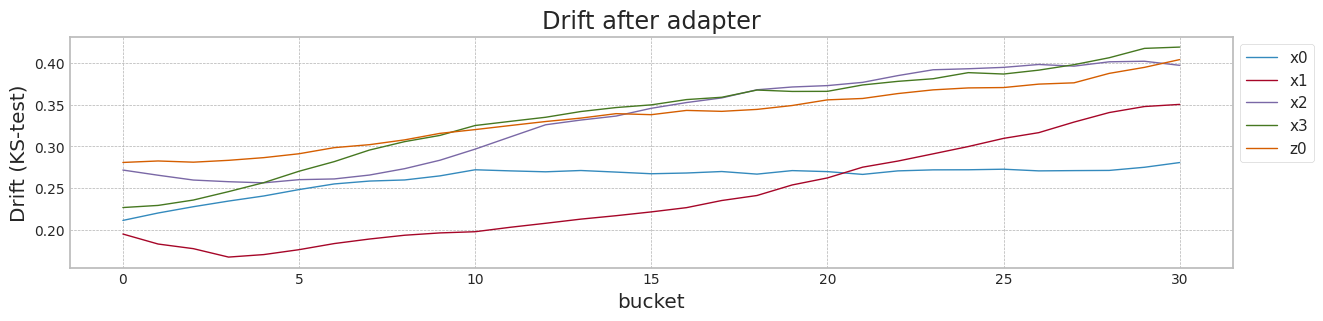

TrainStd(MI) min_lambda= 0.0


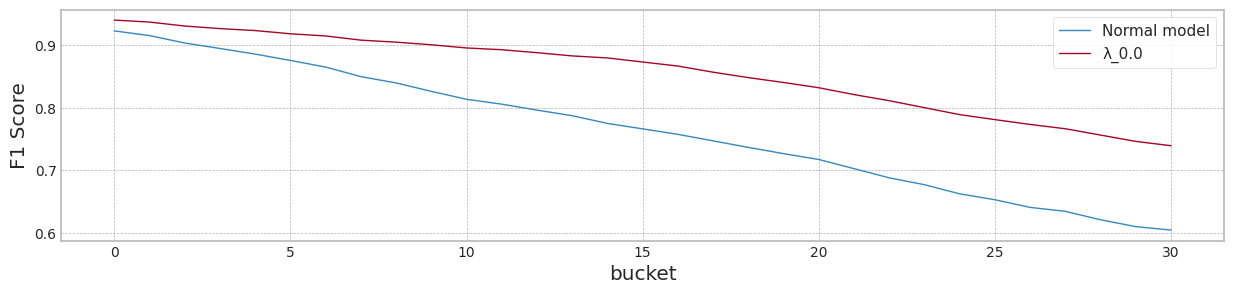

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.922727  0.922727  0.764258  0.604010    0.740659   
1                     0.0  0.940004  0.940004  0.856062  0.739001    0.740515   
2                     0.1  0.939198  0.939198  0.869863  0.806967    0.739134   
3                     0.2  0.937627  0.937627  0.860125  0.790049    0.737415   
4                     0.3  0.930036  0.930036  0.816077  0.686363    0.739818   
5                     0.4  0.928872  0.928872  0.793951  0.637175    0.739084   
6                     0.5  0.926555  0.926555  0.777880  0.601054    0.739560   
7                     0.6  0.923399  0.923399  0.758738  0.563617    0.741222   
8                     0.7  0.920292  0.920292  0.740810  0.531281    0.739396   
9                     0.8  0.916423  0.916423  0.732990  0.531380    0.739109   
10                    0.9  0.912954  0.912954  0.722599  0.524900    0.740326   

    Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR8.0)  \
0     0.147834    1.064643    0.341000    0.052764  ...    1.265173   
1     0.147841    1.064368    4.719111    0.110641  ...    1.594733   
2     0.147855    1.061756    1.289556    0.045374  ...    1.596685   
3     0.148076    1.053747    1.163667    0.089276  ...    1.598757   
4     0.147564    1.065840    1.256000    0.133248  ...    1.516625   
5     0.147775    1.062265    1.164222    0.145574  ...    1.483116   
6     0.147753    1.063292    0.960556    0.109003  ...    1.565339   
7     0.147384    1.069440    0.809889    0.082886  ...    1.584469   
8     0.147801    1.062807    0.670222    0.063158  ...    1.563994   
9     0.147754    1.062460    0.536111    0.050647  ...    1.567001   
10    0.147808    1.064850    0.421778    0.047752  ...    1.523115   

    TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0       0.674754      0.118196      1.196888      0.648423      0.113436   
1       0.641034      0.111243      1.207619      0.607567      0.108426   
2       0.701900      0.118581      1.199778      0.677625      0.114225   
3       0.701525      0.120621      1.199812      0.665397      0.112232   
4       0.692271      0.119283      1.184559      0.660312      0.113197   
5       0.679682      0.119205      1.195380      0.661555      0.110932   
6       0.684145      0.120077      1.186005      0.668934      0.111741   
7       0.687714      0.120514      1.168511      0.663735      0.115875   
8       0.676982      0.122660      1.147728      0.656354      0.115789   
9       0.676259      0.118521      1.191061      0.643047      0.112565   
10      0.676420      0.120919      1.155702      0.657327      0.113818   

    Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0       1.197710      0.000000      0.000000           NaN  
1       1.183388      4.622556      0.143322      1.596302  
2       1.220619      1.169333      0.032628      1.599862  
3       1.214458      1.013778      0.039081      1.590536  
4       1.203944      1.208222      0.123549      1.494486  
5       1.237378      1.140667      0.139443      1.448167  
6       1.235308      0.887444      0.084975      1.502393  
7       1.180048      0.702556      0.058013      1.523920  
8       1.155594      0.529778      0.039613      1.534695  
9       1.187667      0.361889      0.027175      1.533419  
10      1.188618      0.199111      0.017043      1.514334  

[11 rows x 68 columns]

In [162]:
#bucket_size = 700
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b'])+1)


## real-world data 의 실험

### Loan data 실험

#### Dataset 준비

##### Data load

In [116]:

if False:
    from google.colab import drive
    drive.mount('/content/drive')

In [117]:

df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


##### Data 정제

In [118]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted

(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [119]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

##### Dataset 만들기

In [163]:
X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [164]:

X[2010].shape

(11497, 81)

In [165]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [166]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375577
last_fico_range_high    0.098915
last_pymnt_amnt         0.086038
total_rec_late_fee      0.036917
int_rate                0.019748
                          ...   
G3                      0.000000
G5                      0.000000
Source Verified         0.000000
Verified                0.000000
loan_amnt               0.000000
Name: MI Scores, Length: 81, dtype: float64


In [167]:
# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

+ 일부러 예측 확률을 떨어뜨리기 위해 (조정), "recoveries" feature를 제외 한다.

In [168]:
top_columns = list(mi_scores[1:10].index)
top_columns

['last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate',
 'term',
 'Y',
 'D1',
 'fico_range_high',
 'total_rec_int']

In [169]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2, 1, 80, 38, 6, 13]

In [170]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)[top_columns]
#X2_df_t5 = X2_df[top_columns]

#### 실험

MI Analysis MI Max 0.31562, Min 0.00207, Mean 0.09500, Std 0.10970
Dataset structure X_train, (10000, 9) X_test, (10000, 9) X_live (1278183, 9)
Truncate 8727 rows from live_set (1278183, 9)
Search MI & Drift...for X_live_set (848, 10000, 9)


100%|██████████| 848/848 [05:08<00:00,  2.75it/s]


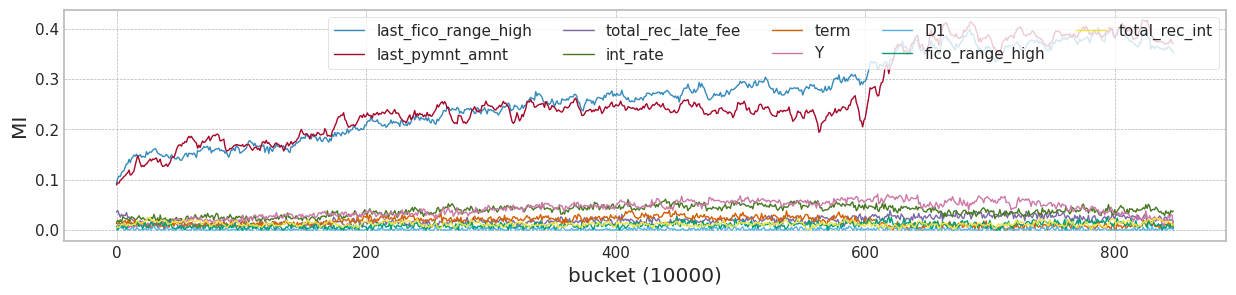

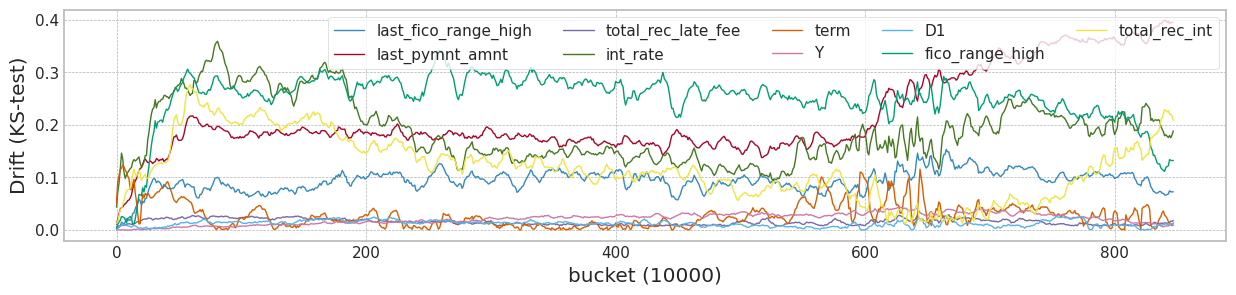

In [171]:
train_size = 10000
test_size = 1497

X1,Y1 = check_mi_drift(X2, Y2, train_size, test_size)

In [172]:
bucket_size = 5000
X1['b'] = [int(b/bucket_size) for b in X1.index.values]
X1

last_fico_range_high  last_pymnt_amnt  total_rec_late_fee  int_rate  \
0                    0.928910         0.032896            0.000000  0.502466   
1                    0.863744         0.010440            0.000000  0.416769   
2                    0.727488         0.381296            0.000000  0.566584   
3                    0.869668         0.021731            0.000000  0.652281   
4                    0.952607         0.027513            0.000000  0.395191   
...                       ...              ...                 ...       ...   
1279675              0.917062         0.000269            0.090128  0.278052   
1279676              0.857820         0.403841            0.000000  0.278052   
1279677              0.905213         0.334665            0.000000  0.157213   
1279678              0.922986         0.971979            0.000000 -0.006165   
1279679              0.881517         0.377212            0.000000  1.564118   

         term    Y   D1  fico_range_high  total_rec_int    b  
0         0.0  0.0  0.0          0.12500       0.175629    0  
1         0.0  0.0  0.0          0.62500       0.097918    0  
2         0.0  0.0  1.0          0.31250       0.023318    0  
3         0.0  0.0  0.0          0.00000       0.262327    0  
4         0.0  0.0  0.0          0.59375       0.253892    0  
...       ...  ...  ...              ...            ...  ...  
1279675   0.0  0.0  0.0          0.25000       0.031754  255  
1279676   0.0  0.0  0.0          0.46875       0.099365  255  
1279677   0.0  0.0  0.0          0.28125       0.026058  255  
1279678   0.0  0.0  0.0          0.71875       0.085987  255  
1279679   1.0  0.0  0.0          0.34375       0.186533  255  

[1279680 rows x 10 columns]

lambda_f2 1.0
######################### Lambda -0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:06<00:00, 632.49it/s]


Test f1 score: 0.9392054136651384
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:09<00:00,  2.74it/s]


mean of drift:
last_fico_range_high    0.117682
last_pymnt_amnt         0.214501
total_rec_late_fee      0.019389
int_rate                0.187503
term                    0.028391
Y                       0.021749
D1                      0.012171
fico_range_high         0.250177
total_rec_int           0.117911
dtype: float64
Mean F1 for all data: 0.9200797786968224
######################### Lambda 0.0 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 169.55it/s]


Test f1 score: 0.9303668841587335
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:06<00:00,  2.76it/s]


mean of drift:
last_fico_range_high    1.000000
last_pymnt_amnt         0.985588
total_rec_late_fee      0.945700
int_rate                0.992227
term                    0.745600
Y                       1.000000
D1                      0.972900
fico_range_high         0.464948
total_rec_int           0.866485
dtype: float64
Mean F1 for all data: 0.8879347926553869
######################### Lambda 0.1 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 168.68it/s]


Test f1 score: 0.9480787463052813
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:07<00:00,  2.75it/s]


mean of drift:
last_fico_range_high    0.417739
last_pymnt_amnt         0.947118
total_rec_late_fee      0.991011
int_rate                0.875919
term                    0.742092
Y                       0.989511
D1                      0.979643
fico_range_high         0.401468
total_rec_int           0.882120
dtype: float64
Mean F1 for all data: 0.9331556107383748
######################### Lambda 0.2 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 167.71it/s]


Test f1 score: 0.9464951840097989
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:12<00:00,  2.71it/s]


mean of drift:
last_fico_range_high    0.241303
last_pymnt_amnt         0.892173
total_rec_late_fee      0.992033
int_rate                0.831784
term                    0.741454
Y                       0.981477
D1                      0.972900
fico_range_high         0.363921
total_rec_int           0.611011
dtype: float64
Mean F1 for all data: 0.8897696668338438
######################### Lambda 0.3 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 167.15it/s]


Test f1 score: 0.9453254962847955
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:15<00:00,  2.69it/s]


mean of drift:
last_fico_range_high    0.629444
last_pymnt_amnt         0.462480
total_rec_late_fee      0.991308
int_rate                0.840597
term                    0.744498
Y                       0.976438
D1                      0.972900
fico_range_high         0.423730
total_rec_int           0.666094
dtype: float64
Mean F1 for all data: 0.891813316466846
######################### Lambda 0.4 ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 165.23it/s]


Test f1 score: 0.9449089197718843
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:13<00:00,  2.71it/s]


mean of drift:
last_fico_range_high    0.507611
last_pymnt_amnt         0.437991
total_rec_late_fee      0.990620
int_rate                0.708290
term                    0.754200
Y                       0.986012
D1                      0.972900
fico_range_high         0.426357
total_rec_int           0.447388
dtype: float64
Mean F1 for all data: 0.8902437725334147
######################### Lambda 0.5 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 166.72it/s]


Test f1 score: 0.9437631200972268
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:16<00:00,  2.68it/s]


mean of drift:
last_fico_range_high    0.238501
last_pymnt_amnt         0.442806
total_rec_late_fee      0.990783
int_rate                0.527096
term                    0.758818
Y                       0.977866
D1                      0.972900
fico_range_high         0.415842
total_rec_int           0.468293
dtype: float64
Mean F1 for all data: 0.8907424200285954
######################### Lambda 0.6 ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 165.79it/s]


Test f1 score: 0.9427468284611141
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:10<00:00,  2.73it/s]


mean of drift:
last_fico_range_high    0.597725
last_pymnt_amnt         0.501758
total_rec_late_fee      0.989442
int_rate                0.261052
term                    0.758503
Y                       0.974018
D1                      0.972900
fico_range_high         0.406394
total_rec_int           0.543732
dtype: float64
Mean F1 for all data: 0.8926127786272234
######################### Lambda 0.7 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 167.21it/s]


Test f1 score: 0.9428587202561697
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:10<00:00,  2.73it/s]


mean of drift:
last_fico_range_high    0.570636
last_pymnt_amnt         0.377312
total_rec_late_fee      0.987080
int_rate                0.181954
term                    0.758503
Y                       0.972314
D1                      0.972900
fico_range_high         0.394414
total_rec_int           0.564296
dtype: float64
Mean F1 for all data: 0.894385372538395
######################### Lambda 0.8 ###########################
cuda:0


100%|██████████| 4000/4000 [00:23<00:00, 167.70it/s]


Test f1 score: 0.9422041533897374
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:12<00:00,  2.71it/s]


mean of drift:
last_fico_range_high    0.222762
last_pymnt_amnt         0.403725
total_rec_late_fee      0.970083
int_rate                0.170444
term                    0.758186
Y                       0.973549
D1                      0.972900
fico_range_high         0.374989
total_rec_int           0.570939
dtype: float64
Mean F1 for all data: 0.9208343626839542
######################### Lambda 0.9 ###########################
cuda:0


100%|██████████| 4000/4000 [00:24<00:00, 165.79it/s]


Test f1 score: 0.9411184210526317
X_live.shape (1278183, 10)
Truncate 8727 rows from live_set (1278183, 10)
Search MI & Drift...for X_live_set torch.Size([848, 10000, 10])


100%|██████████| 848/848 [05:14<00:00,  2.69it/s]


mean of drift:
last_fico_range_high    0.292425
last_pymnt_amnt         0.411628
total_rec_late_fee      0.989665
int_rate                0.169505
term                    0.757623
Y                       0.992079
D1                      0.972900
fico_range_high         0.348666
total_rec_int           0.555170
dtype: float64
Mean F1 for all data: 0.7561846338105681


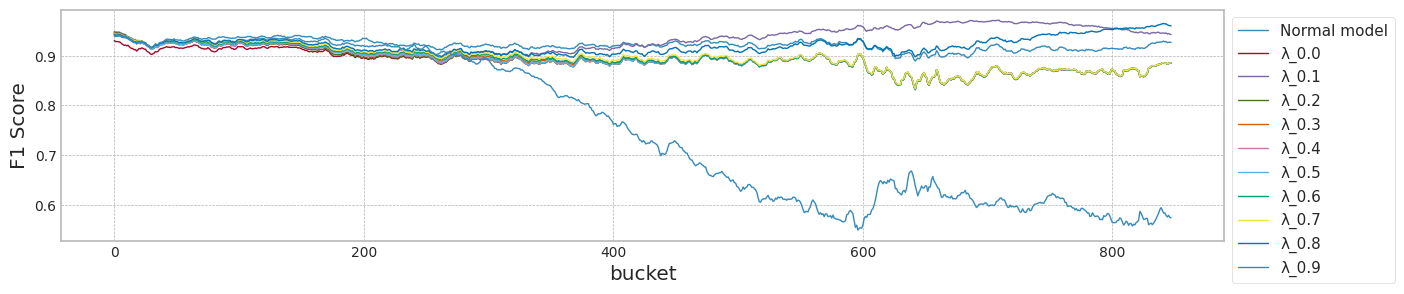

max_mean_lambda= 0.1


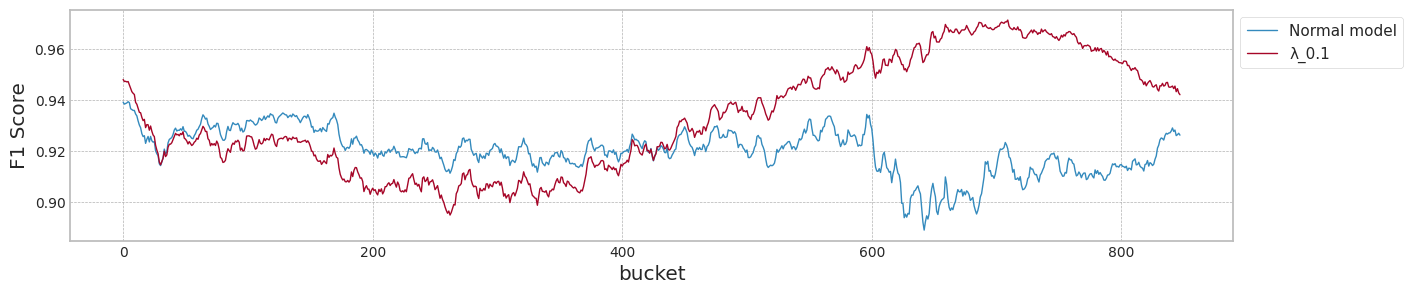

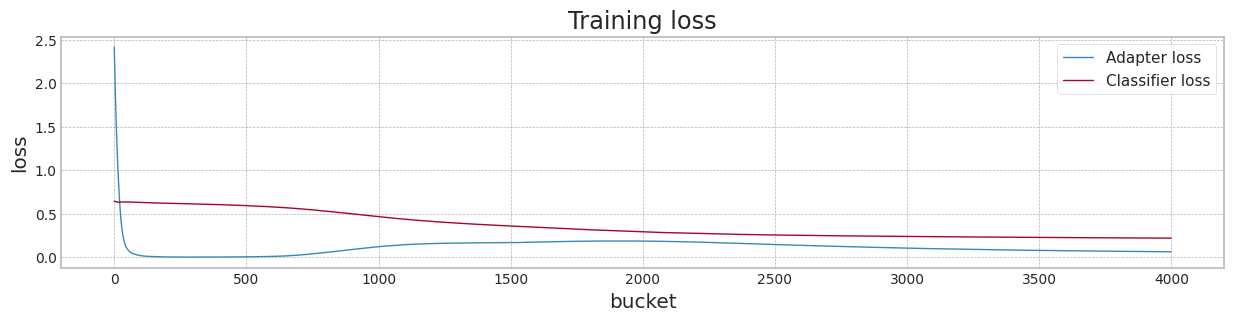

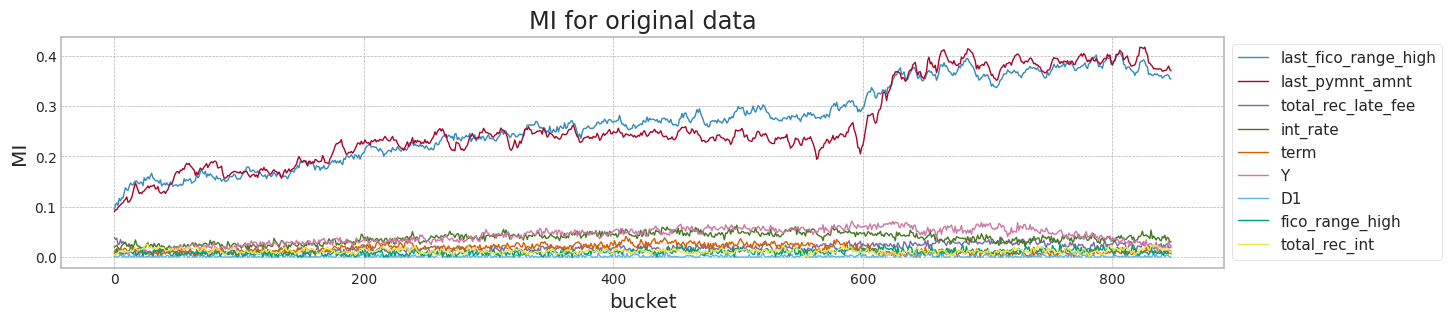

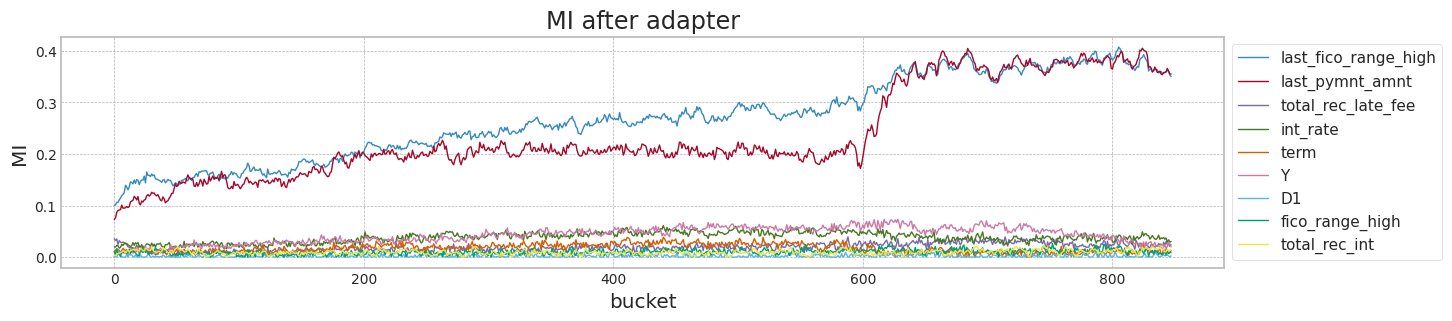

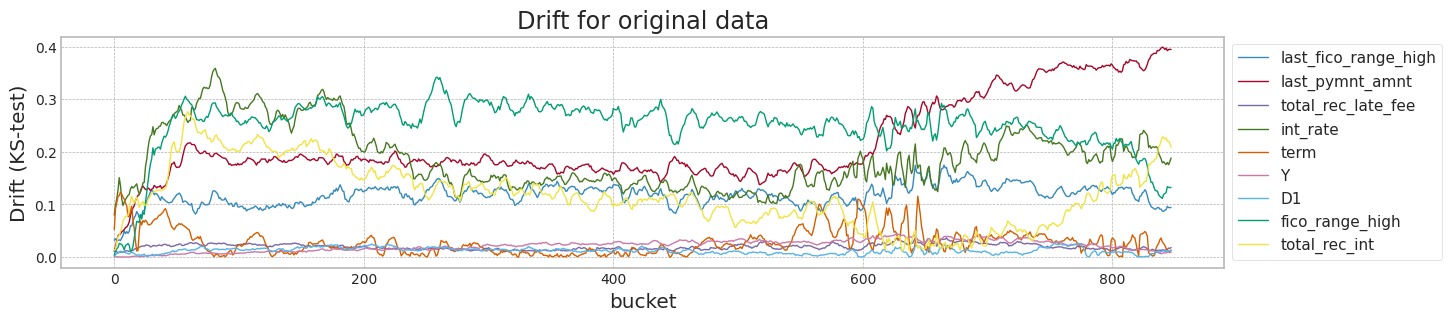

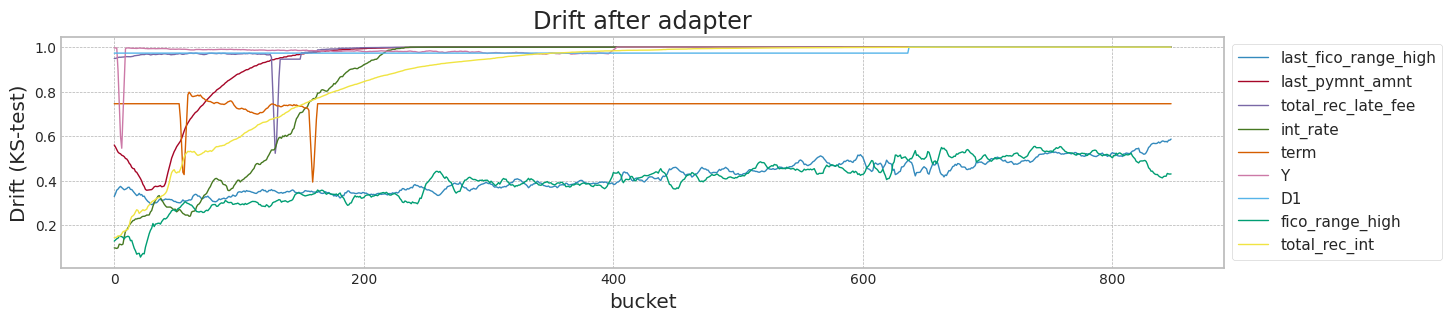

TrainStd(MI) min_lambda= 0.1


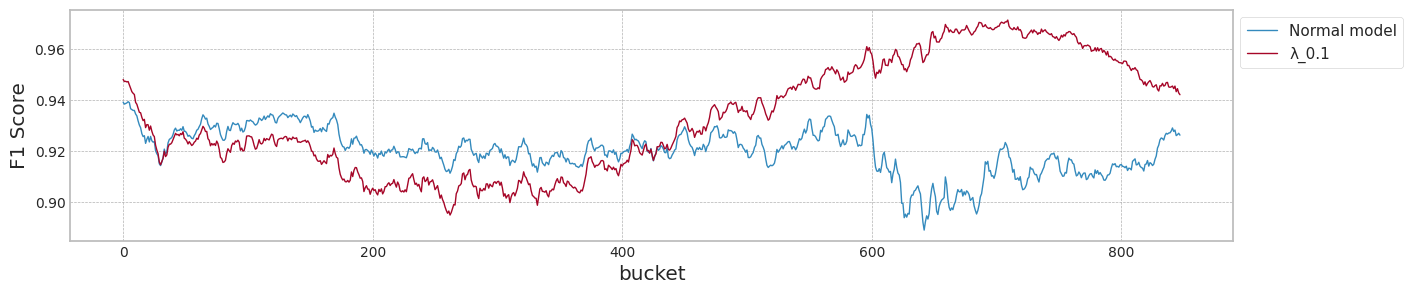

lambda   test_f1   init_f1   mean_f1   last_f1  Sum(MI0.0)  \
0   Case #1, Normal model  0.939205  0.939205  0.920080  0.926318    0.229823   
1                     0.0  0.930367  0.930367  0.887935  0.884675    0.237284   
2                     0.1  0.948079  0.948079  0.933156  0.942139    0.229771   
3                     0.2  0.946495  0.946495  0.889770  0.884725    0.230368   
4                     0.3  0.945325  0.945325  0.891813  0.885268    0.229605   
5                     0.4  0.944909  0.944909  0.890244  0.884873    0.229669   
6                     0.5  0.943763  0.943763  0.890742  0.885021    0.229433   
7                     0.6  0.942747  0.942747  0.892613  0.885070    0.229473   
8                     0.7  0.942859  0.942859  0.894385  0.885206    0.230378   
9                     0.8  0.942204  0.942204  0.920834  0.959694    0.230729   
10                    0.9  0.941118  0.941118  0.756185  0.574304    0.230224   

    Std(MI0.0)  Ent(MI0.0)  Sum(DR0.0)  Std(DR0.0)  ...  Ent(DR1.0)  \
0     0.028921    1.590997      0.2526    0.034959  ...    1.592297   
1     0.029345    1.618617      7.8143    0.166148  ...    2.177424   
2     0.028926    1.593277      4.9551    0.357572  ...    1.964029   
3     0.028808    1.598294      4.8222    0.369443  ...    1.916938   
4     0.028926    1.590977      4.6726    0.383718  ...    1.881704   
5     0.028943    1.591064      4.6290    0.387030  ...    1.858776   
6     0.028929    1.590179      4.5655    0.389901  ...    1.843470   
7     0.028948    1.591004      4.5202    0.391800  ...    1.841965   
8     0.029005    1.591087      4.4744    0.394990  ...    1.808290   
9     0.028970    1.593911      4.3330    0.404042  ...    1.788212   
10    0.028936    1.592609      4.2082    0.411406  ...    1.744005   

    TrainSum(MI)  TrainStd(MI)  TrainEnt(MI)  Test Sum(MI)  Test Std(MI)  \
0       0.256944      0.032310      1.592832      0.266351      0.034842   
1       0.248973      0.030695      1.660341      0.257290      0.032642   
2       0.246277      0.029761      1.682789      0.259758      0.031977   
3       0.254417      0.030597      1.688047      0.263673      0.032538   
4       0.252347      0.030805      1.671595      0.261505      0.032991   
5       0.254082      0.031483      1.648012      0.265974      0.032880   
6       0.256188      0.030411      1.702243      0.275173      0.033245   
7       0.252944      0.031140      1.660735      0.262372      0.033311   
8       0.246533      0.030546      1.649577      0.256353      0.032811   
9       0.252432      0.030358      1.687187      0.259688      0.032579   
10      0.255435      0.030540      1.695063      0.267111      0.033504   

    Test Ent(MI)  Test Sum(DR)  Test Std(DR)  Test Ent(DR)  
0       1.571841        0.0000      0.000000           NaN  
1       1.607840        7.7585      0.171452      2.175834  
2       1.650199        4.8719      0.358310      1.951116  
3       1.650193        4.7108      0.373627      1.907406  
4       1.622256        4.5848      0.385371      1.866017  
5       1.646871        4.0501      0.338224      1.873656  
6       1.677043        3.9842      0.341689      1.857549  
7       1.613562        3.7616      0.319878      1.867107  
8       1.588677        4.0761      0.363515      1.822218  
9       1.628607        3.5975      0.328684      1.818322  
10      1.629597        3.5550      0.350721      1.760778  

[11 rows x 26 columns]

In [173]:
result_df = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 300) # np.max(X1['b'])+1)
result_df

### Card data 실험

#### Dataset 준비

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download "ealtman2019/credit-card-transactions"

 95% 249M/263M [00:02<00:00, 105MB/s]
100% 263M/263M [00:02<00:00, 112MB/s]


In [ ]:
!unzip credit-card-transactions.zip

Archive:  credit-card-transactions.zip
  inflating: User0_credit_card_transactions.csv  
  inflating: credit_card_transactions-ibm_v2.csv  
  inflating: sd254_cards.csv         
  inflating: sd254_users.csv         


In [ ]:
df = pd.read_csv("credit_card_transactions-ibm_v2.csv")

In [ ]:
df['Year'].value_counts()

2019    1723938
2017    1723360
2018    1721615
2016    1708924
2015    1701371
2014    1672343
2013    1650917
2012    1610829
2011    1570551
2010    1491225
2009    1355434
2008    1223460
2007    1064483
2006     908793
2005     746653
2004     597003
2003     466408
2002     350732
2020     336500
2001     257998
2000     177729
1999     118250
1998      78345
1997      49753
1996      29945
1995      20928
1994      14316
1993       8378
1992       5134
1991       1585
Name: Year, dtype: int64

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1})
df1 = df[df['Is Fraud?']==1]
df2 = df[df['Is Fraud?']==0]
df3 = df2.sample(int(df2.shape[0]/30))
df4 = pd.concat([df1,df3])

print("Compression rate:",df4.shape[0] / df.shape[0] )

df = df4

Compression rate: 0.034512832709364456


In [ ]:
df['Errors?']=df['Errors?'].fillna('NAN')
df['Errors?']=df['Errors?'].apply(lambda value:value=='NAN')
df['Errors?'].value_counts()

df['Use Chip'].unique()
df['is online']=df['Use Chip'].apply(lambda value:value=='Online Transaction')

from sklearn.preprocessing import LabelEncoder
df['Use Chip']=df['Use Chip'].replace({'Swipe Transaction':0, 'Online Transaction':1, 'Chip Transaction':2})
df['Zip'] = df['Zip'].fillna(df['Zip'].mean())
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Hour'] = df['Time'].apply(lambda value: int(value.split(":")[0]))
df['Minutes'] = df['Time'].apply(lambda value: int(value.split(":")[1]))
df.drop(['Time'], axis=1, inplace=True)
df['Merchant State']=df['Merchant State'].fillna('NAN')
df['Merchant City']=df['Merchant City'].fillna('NAN')
df['is vozmes']=df['Amount'].apply(lambda value: value<0)
df['abs_amount']=df['Amount'].apply(lambda value: abs(value))

#encoding categorial features
le=LabelEncoder()
df['Merchant State']=le.fit_transform(df['Merchant State'])
le=LabelEncoder()
df['Merchant City']=le.fit_transform(df['Merchant City'])
le=LabelEncoder()
df['Errors?']=le.fit_transform(df['Errors?'])
le=LabelEncoder()
df['is online']=le.fit_transform(df['is online'])
le=LabelEncoder()
df['is vozmes']=le.fit_transform(df['is vozmes'])

df = df.sort_values(['Year','Month','Day'])

df.Year.value_counts()

2016    60412
2015    60116
2018    59563
2019    59488
2017    57276
2013    57029
2014    56782
2012    54838
2010    53127
2011    52594
2009    46612
2008    44566
2007    37404
2006    31560
2005    25216
2004    20436
2003    15753
2002    11773
2020    11251
2001     8820
2000     6049
1999     3969
1998     2689
1997     1641
1996      968
1995      691
1994      511
1993      276
1992      185
1991       66
Name: Year, dtype: int64

In [ ]:
drop_columns = ['Is Fraud?','Zip','Year','Month','Day','Minutes','User','Errors?','Merchant Name','Merchant City','Merchant State']
X = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)].drop(drop_columns,axis=1)
y = df[(df['Year']==2005) |(df['Year']==2006) | (df['Year']==2007) | (df['Year']==2008) | (df['Year']==2009)]['Is Fraud?']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185358 entries, 17325692 to 342823
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Card        185358 non-null  int64  
 1   Amount      185358 non-null  float64
 2   Use Chip    185358 non-null  int64  
 3   MCC         185358 non-null  int64  
 4   is online   185358 non-null  int64  
 5   Hour        185358 non-null  int64  
 6   is vozmes   185358 non-null  int64  
 7   abs_amount  185358 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 12.7 MB


In [ ]:
np.sum(y[0:30000])

536

#### 실험

MI Analysis MI Max 0.04861, Min 0.00078, Mean 0.01996, Std 0.01460
Dataset structure X_train, (30000, 8) X_test, (30000, 8) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)
Search MI & Drift...for X_live_set (51, 30000, 8)


100%|██████████| 51/51 [00:54<00:00,  1.06s/it]


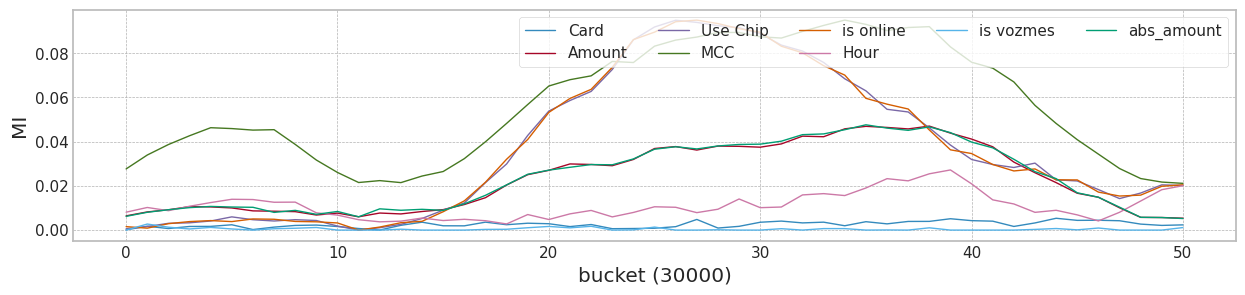

In [ ]:

train_size = 30000
test_size = 3000

X1,Y1 = check_mi_drift(X, y.values,train_size, test_size)

MI Analysis MI Max 0.02838, Min 0.00038, Mean 0.00683, Std 0.00866
cuda:0


100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

MSE: 0.10
RMSE: 0.32


F1 Score:0.00000
Dataset structure X_train, torch.Size([30000, 8]) X_test, torch.Size([30000, 8]) X_live (182358, 8)
Truncate 156222 rows from live_set (182358, 8)


100%|██████████| 51/51 [00:00<00:00, 96.38it/s]


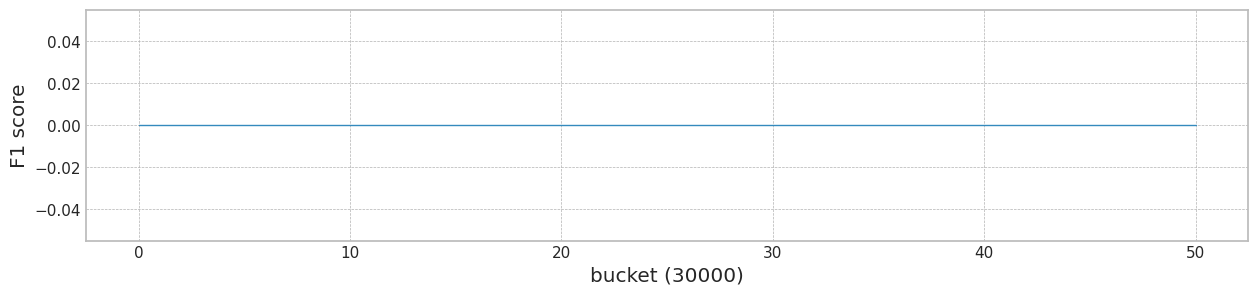

   test_f1  init_f1  mean_f1  last_f1   SUM(MI)
0      0.0      0.0      0.0      0.0  0.054619


In [ ]:
model,df = train_classificaion_model(X1,Y1,train_size, test_size)